# Compas Analysis

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.

## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [1]:
# filter dplyr warnings
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

Error importing in API mode: ImportError("dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <20FB70DB-7E84-3375-A520-E0350E06C060> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
%%R
library(dplyr)
library(ggplot2)
raw_data <- read.csv("./compas-scores-two-years.csv")
nrow(raw_data)
head(raw_data)

  id               name  first        last compas_screening_date  sex
1  1   miguel hernandez miguel   hernandez            2013-08-14 Male
2  3        kevon dixon  kevon       dixon            2013-01-27 Male
3  4           ed philo     ed       philo            2013-04-14 Male
4  5        marcu brown  marcu       brown            2013-01-13 Male
5  6 bouthy pierrelouis bouthy pierrelouis            2013-03-26 Male
6  7       marsha miles marsha       miles            2013-11-30 Male
         dob age         age_cat             race juv_fel_count decile_score
1 1947-04-18  69 Greater than 45            Other             0            1
2 1982-01-22  34         25 - 45 African-American             0            3
3 1991-05-14  24    Less than 25 African-American             0            4
4 1993-01-21  23    Less than 25 African-American             0            8
5 1973-01-22  43         25 - 45            Other             0            1
6 1971-08-22  44         25 - 45            Othe


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [3]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
nrow(df)

[1] 6172


Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [4]:
%%R
df$length_of_stay <- as.numeric(as.Date(df$c_jail_out) - as.Date(df$c_jail_in))
cor(df$length_of_stay, df$decile_score)

[1] 0.2073297


After filtering we have the following demographic breakdown:

In [5]:
%%R
summary(df$age_cat)

   Length     Class      Mode 
     6172 character character 


In [6]:
%%R
summary(df$race)

   Length     Class      Mode 
     6172 character character 


In [7]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [8]:
%%R
summary(df$score_text)

   Length     Class      Mode 
     6172 character character 


In [9]:
%%R
xtabs(~ sex + race, data=df)

        race
sex      African-American Asian Caucasian Hispanic Native American Other
  Female              549     2       482       82               2    58
  Male               2626    29      1621      427               9   285


In [10]:
%%R
summary(df$sex)

   Length     Class      Mode 
     6172 character character 


In [11]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [12]:
%%R
nrow(filter(df, two_year_recid == 1))

[1] 2809


In [13]:
%%R
nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

[1] 45.51199


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



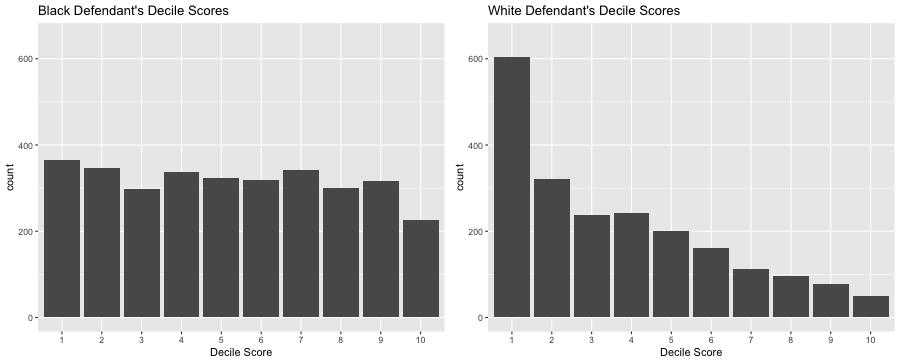

In [14]:
%%R -w 900 -h 363 -u px
library(grid)
library(gridExtra)
pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Decile Score") +
          ylim(0, 650) + ggtitle("Black Defendant's Decile Scores")
pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Decile Score") +
          ylim(0, 650) + ggtitle("White Defendant's Decile Scores")
grid.arrange(pblack, pwhite,  ncol = 2)

In [15]:
%%R
xtabs(~ decile_score + race, data=df)

            race
decile_score African-American Asian Caucasian Hispanic Native American Other
          1               365    15       605      159               0   142
          2               346     4       321       89               2    60
          3               298     5       238       73               1    32
          4               337     0       243       47               0    39
          5               323     1       200       39               0    19
          6               318     2       160       27               2    20
          7               343     1       113       28               2     9
          8               301     2        96       14               0     7
          9               317     0        77       17               2     7
          10              227     1        50       16               2     8


## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [16]:
%%R
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race)) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(score_factor = factor(score_text != "Low", labels = c("LowScore","HighScore")))
model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
summary(model)


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -1.52554    0.07851 -19.430  < 2e-16 ***
gender_factorFemale          0.22127    0.07951   2.783 0.005388 ** 
age_factorGreater than 45   -1.35563    0.09908 -13.682  < 2e-16 ***
age_factorLess than 25       1.30839    0.07593  17.232  < 2e-16 ***
race_factorAfrican-American  0.47721    0.06935   6.881 5.93e-12 ***
race_factorAsian            -0.25441    0.47821  -0.532 0.594717    
race_factorHispanic         -0.42839    0.12813  -3.344 0.000827 ***
race_factorNative American   1.39421    0.76612   1.820 0.068784 .  
race_factorOther            -0.82635    0.16208  -5.098 3.43e-07 ***
priors_count                 0.26895    0.01110  24.221  < 2e-16 ***
crime_factorM               -0.31124    0.06655  -4.677 2.9

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [17]:
%%R
control <- exp(-1.52554) / (1 + exp(-1.52554))
exp(0.47721) / (1 - control + (control * exp(0.47721)))

[1] 1.452841


Women are 19.4% more likely than men to get a higher score.

In [18]:
%%R
exp(0.22127) / (1 - control + (control * exp(0.22127)))

[1] 1.194798


Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [19]:
%%R
exp(1.30839) / (1 - control + (control * exp(1.30839)))

[1] 2.49612


### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [20]:
%%R
raw_data <- read.csv("./compas-scores-two-years-violent.csv")
nrow(raw_data)

[1] 4743


In [21]:
%%R
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, v_score_text, sex, priors_count, 
                    days_b_screening_arrest, v_decile_score, is_recid, two_year_recid) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>% 
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(v_score_text != 'N/A')
nrow(df)

[1] 4020


In [22]:
%%R
summary(df$age_cat)

   Length     Class      Mode 
     4020 character character 


In [23]:
%%R
summary(df$race)

   Length     Class      Mode 
     4020 character character 


In [24]:
%%R
summary(df$v_score_text)

   Length     Class      Mode 
     4020 character character 


In [25]:
%%R
nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

[1] 16.21891


In [26]:
%%R
nrow(filter(df, two_year_recid == 1))

[1] 652


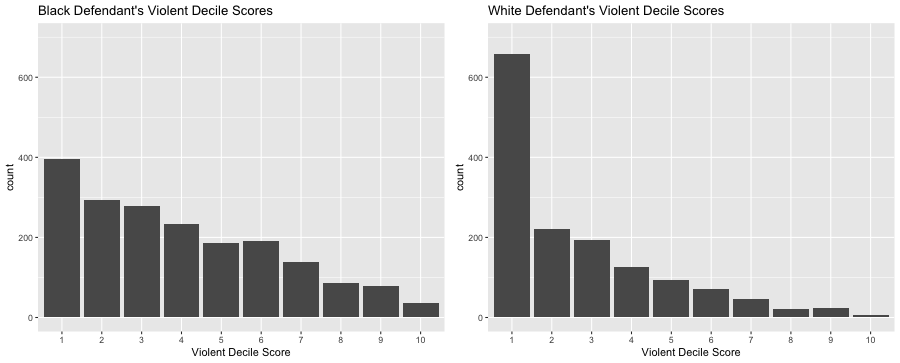

In [27]:
%%R -w 900 -h 363 -u px
library(grid)
library(gridExtra)
pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(v_decile_score))) + 
          geom_bar() + xlab("Violent Decile Score") +
          ylim(0, 700) + ggtitle("Black Defendant's Violent Decile Scores")
pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(v_decile_score))) + 
          geom_bar() + xlab("Violent Decile Score") +
          ylim(0, 700) + ggtitle("White Defendant's Violent Decile Scores")
grid.arrange(pblack, pwhite,  ncol = 2)

In [28]:
%%R
df <- mutate(df, crime_factor = factor(c_charge_degree)) %>%
      mutate(age_factor = as.factor(age_cat)) %>%
      within(age_factor <- relevel(age_factor, ref = 1)) %>%
      mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
      within(race_factor <- relevel(race_factor, ref = 3)) %>%
      mutate(gender_factor = factor(sex, labels= c("Female","Male"))) %>%
      within(gender_factor <- relevel(gender_factor, ref = 2)) %>%
      mutate(score_factor = factor(v_score_text != "Low", labels = c("LowScore","HighScore")))
model <- glm(score_factor ~ gender_factor + age_factor + race_factor +
                            priors_count + crime_factor + two_year_recid, family="binomial", data=df)
summary(model)


Call:
glm(formula = score_factor ~ gender_factor + age_factor + race_factor + 
    priors_count + crime_factor + two_year_recid, family = "binomial", 
    data = df)

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -2.24274    0.11326 -19.802  < 2e-16 ***
gender_factorFemale         -0.72890    0.12666  -5.755 8.66e-09 ***
age_factorGreater than 45   -1.74208    0.18415  -9.460  < 2e-16 ***
age_factorLess than 25       3.14591    0.11541  27.259  < 2e-16 ***
race_factorAfrican-American  0.65893    0.10815   6.093 1.11e-09 ***
race_factorAsian            -0.98521    0.70537  -1.397   0.1625    
race_factorHispanic         -0.06416    0.19133  -0.335   0.7374    
race_factorNative American   0.44793    1.03546   0.433   0.6653    
race_factorOther            -0.20543    0.22464  -0.914   0.3605    
priors_count                 0.13764    0.01161  11.854  < 2e-16 ***
crime_factorM               -0.16367    0.09807  -1.669   0

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

In [29]:
%%R
control <- exp(-2.24274) / (1 + exp(-2.24274))
exp(0.65893) / (1 - control + (control * exp(0.65893)))

[1] 1.773921


Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

In [30]:
%%R
exp(3.14591) / (1 - control + (control * exp(3.14591)))

[1] 7.41424


## Predictive Accuracy of COMPAS

In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk,  we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).

We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [31]:
%%R
library(survival)
library(ggfortify)

data <- filter(filter(read.csv("./cox-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))

grp <- data[!duplicated(data$id),]
nrow(grp)

[1] 10314


In [32]:
%%R
summary(grp$score_factor)

   Low   High Medium 
  5751   1952   2611 


In [33]:
%%R
summary(grp$race_factor)

       Caucasian African-American            Asian         Hispanic 
            3569             5147               51              944 
 Native American            Other 
              32              571 


In [34]:
%%R
f <- Surv(start, end, event, type="counting") ~ score_factor
model <- coxph(f, data=data)
summary(model)

Call:
coxph(formula = f, data = data)

  n= 13344, number of events= 3469 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.24969   3.48927  0.04146 30.14   <2e-16 ***
score_factorMedium 0.79627   2.21725  0.04077 19.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.489     0.2866     3.217     3.785
score_factorMedium     2.217     0.4510     2.047     2.402

Concordance= 0.636  (se = 0.005 )
Likelihood ratio test= 942.8  on 2 df,   p=<2e-16
Wald test            = 954.8  on 2 df,   p=<2e-16
Score (logrank) test = 1055  on 2 df,   p=<2e-16



People placed in the High category are 3.5 times as likely to recidivate, and the COMPAS system's concordance 63.6%. This is lower than the accuracy quoted in the Northpoint study of 68%.

In [35]:
%%R
decile_f <- Surv(start, end, event, type="counting") ~ decile_score
dmodel <- coxph(decile_f, data=data)
summary(dmodel)

Call:
coxph(formula = decile_f, data = data)

  n= 13344, number of events= 3469 

                 coef exp(coef) se(coef)     z Pr(>|z|)    
decile_score 0.194931  1.215228 0.005801 33.61   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             exp(coef) exp(-coef) lower .95 upper .95
decile_score     1.215     0.8229     1.201     1.229

Concordance= 0.664  (se = 0.005 )
Likelihood ratio test= 1112  on 1 df,   p=<2e-16
Wald test            = 1129  on 1 df,   p=<2e-16
Score (logrank) test = 1208  on 1 df,   p=<2e-16



COMPAS's decile scores are a bit more accurate at 66%.

We can test if the algorithm is behaving differently across races by including a race interaction term in the cox model.

In [36]:
%%R
f2 <- Surv(start, end, event, type="counting") ~ race_factor + score_factor + race_factor * score_factor
model <- coxph(f2, data=data)
print(summary(model))

Call:
coxph(formula = f2, data = data)

  n= 13344, number of events= 3469 

                                                   coef exp(coef) se(coef)
race_factorAfrican-American                     0.27879   1.32154  0.06080
race_factorAsian                               -0.77694   0.45981  0.50200
race_factorHispanic                            -0.06352   0.93846  0.09673
race_factorNative American                     -1.25468   0.28517  1.00100
race_factorOther                                0.01419   1.01429  0.11049
score_factorHigh                                1.28350   3.60927  0.08357
score_factorMedium                              0.84286   2.32301  0.07142
race_factorAfrican-American:score_factorHigh   -0.18976   0.82716  0.09985
race_factorAsian:score_factorHigh               1.31556   3.72684  0.76835
race_factorHispanic:score_factorHigh           -0.11913   0.88769  0.19833
race_factorNative American:score_factorHigh     1.95571   7.06896  1.08336
race_factorOther:score_

The interaction term shows a similar disparity as the logistic regression above.

High risk white defendants are 3.61 more likely than low risk white defendants, while High risk black defendants are 2.99 more likely than low.

In [37]:
import math
print("Black High Hazard: %.2f" % (math.exp(-0.18976 + 1.28350)))
print("White High Hazard: %.2f" % (math.exp(1.28350)))
print("Black Medium Hazard: %.2f" % (math.exp(0.84286-0.17261)))
print("White Medium Hazard: %.2f" % (math.exp(0.84286)))

Black High Hazard: 2.99
White High Hazard: 3.61
Black Medium Hazard: 1.95
White Medium Hazard: 2.32


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


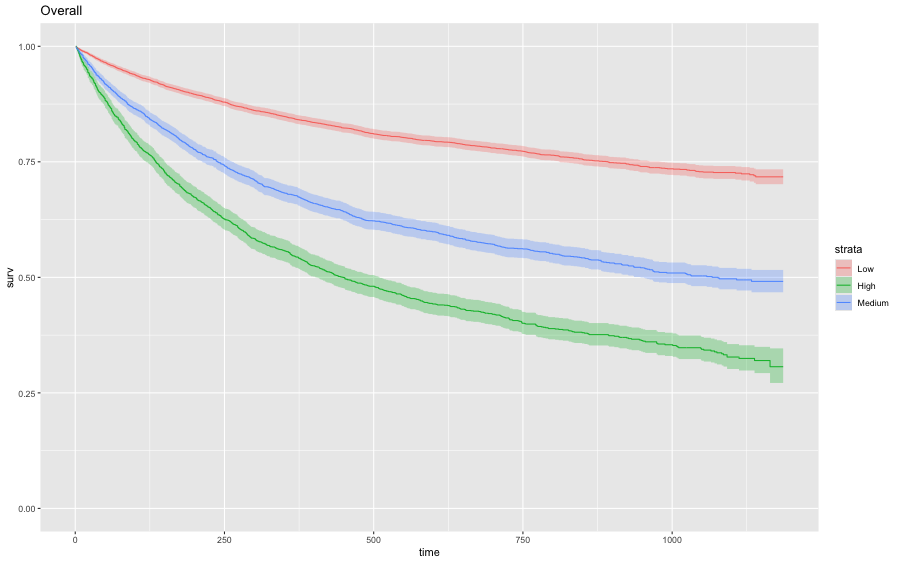

In [38]:
%%R -w 900 -h 563 -u px

fit <- survfit(f, data=data)

plotty <- function(fit, title) {
  return(autoplot(fit, conf.int=T, censor=F) + ggtitle(title) + ylim(0,1))
}
plotty(fit, "Overall")

Black defendants do recidivate at higher rates according to race specific Kaplan Meier plots.

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


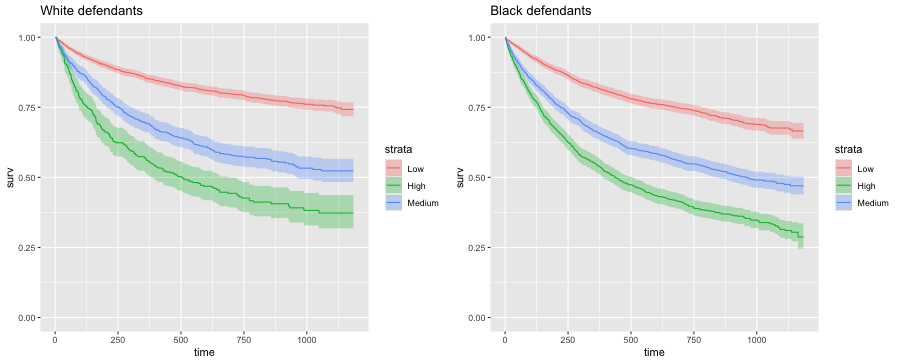

In [39]:
%%R -w 900 -h 363 -u px
white <- filter(data, race == "Caucasian")
white_fit <- survfit(f, data=white)

black <- filter(data, race == "African-American")
black_fit <- survfit(f, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)

In [40]:
%%R
summary(fit, times=c(730))

Call: survfit(formula = f, data = data)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     2.75e+03     1.21e+03     7.76e-01     5.74e-03     7.64e-01 
upper 95% CI 
    7.87e-01 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     505.0000     972.0000       0.4081       0.0122       0.3850 
upper 95% CI 
      0.4327 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     9.79e+02     1.02e+03     5.63e-01     1.03e-02     5.43e-01 
upper 95% CI 
    5.84e-01 



In [41]:
%%R
summary(black_fit, times=c(730))

Call: survfit(formula = f, data = black)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     1.02e+03     5.29e+02     7.43e-01     9.70e-03     7.24e-01 
upper 95% CI 
    7.62e-01 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     362.0000     719.0000       0.3976       0.0142       0.3707 
upper 95% CI 
      0.4265 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     578.0000     623.0000       0.5485       0.0134       0.5227 
upper 95% CI 
      0.5755 



In [42]:
%%R
summary(white_fit, times=c(730))

Call: survfit(formula = f, data = white)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     1.16e+03     4.57e+02     7.95e-01     8.63e-03     7.78e-01 
upper 95% CI 
    8.12e-01 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     102.0000     191.0000       0.4347       0.0272       0.3846 
upper 95% CI 
      0.4914 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     299.0000     306.0000       0.5757       0.0185       0.5405 
upper 95% CI 
      0.6132 



Race specific models have similar concordance values.

In [43]:
%%R
summary(coxph(f, data=white))

Call:
coxph(formula = f, data = white)

  n= 4564, number of events= 1023 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.27628   3.58327  0.08365 15.26   <2e-16 ***
score_factorMedium 0.83965   2.31556  0.07144 11.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.583     0.2791     3.041     4.222
score_factorMedium     2.316     0.4319     2.013     2.664

Concordance= 0.625  (se = 0.008 )
Likelihood ratio test= 262.8  on 2 df,   p=<2e-16
Wald test            = 282.2  on 2 df,   p=<2e-16
Score (logrank) test = 311.7  on 2 df,   p=<2e-16



In [44]:
%%R
summary(coxph(f, data=black))

Call:
coxph(formula = f, data = black)

  n= 6862, number of events= 2035 

                      coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.09514   2.98959  0.05475 20.00   <2e-16 ***
score_factorMedium 0.67025   1.95473  0.05636 11.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       2.990     0.3345     2.685     3.328
score_factorMedium     1.955     0.5116     1.750     2.183

Concordance= 0.623  (se = 0.006 )
Likelihood ratio test= 416.9  on 2 df,   p=<2e-16
Wald test            = 401.3  on 2 df,   p=<2e-16
Score (logrank) test = 433  on 2 df,   p=<2e-16



Compas's violent recidivism score has a slightly higher overall concordance score of 65.1%.

In [45]:
%%R
violent_data <- filter(filter(read.csv("./cox-violent-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))


vf <- Surv(start, end, event, type="counting") ~ score_factor
vmodel <- coxph(vf, data=violent_data)
vgrp <- violent_data[!duplicated(violent_data$id),]
print(nrow(vgrp))
summary(vmodel)

[1] 10985
Call:
coxph(formula = vf, data = violent_data)

  n= 18178, number of events= 818 

                      coef exp(coef) se(coef)      z Pr(>|z|)    
score_factorHigh   1.38311   3.98729  0.08410 16.447   <2e-16 ***
score_factorMedium 0.80350   2.23334  0.08699  9.236   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.987     0.2508     3.381     4.702
score_factorMedium     2.233     0.4478     1.883     2.649

Concordance= 0.651  (se = 0.009 )
Likelihood ratio test= 270.6  on 2 df,   p=<2e-16
Wald test            = 272.2  on 2 df,   p=<2e-16
Score (logrank) test = 307.9  on 2 df,   p=<2e-16



In this case, there isn't a significant coefficient on African American's with High Scores.

In [46]:
%%R
vf2 <- Surv(start, end, event, type="counting") ~ race_factor + race_factor * score_factor
vmodel <- coxph(vf2, data=violent_data)
summary(vmodel)

Call:
coxph(formula = vf2, data = violent_data)

  n= 18178, number of events= 818 

                                                     coef  exp(coef)   se(coef)
race_factorAfrican-American                     1.976e-01  1.219e+00  1.321e-01
race_factorAsian                               -5.838e-01  5.577e-01  1.005e+00
race_factorHispanic                            -1.754e-01  8.391e-01  2.150e-01
race_factorNative American                     -1.304e+01  2.162e-06  7.607e+02
race_factorOther                               -4.459e-02  9.564e-01  2.433e-01
score_factorHigh                                1.250e+00  3.491e+00  1.720e-01
score_factorMedium                              6.292e-01  1.876e+00  1.583e-01
race_factorAfrican-American:score_factorHigh   -7.627e-03  9.924e-01  2.063e-01
race_factorAsian:score_factorHigh               1.552e+00  4.721e+00  1.425e+00
race_factorHispanic:score_factorHigh            1.606e-01  1.174e+00  3.969e-01
race_factorNative American:score_fa

In addition: Warning message:
In agreg.fit(X, Y, istrat, offset, init, control, weights = weights,  :
  Loglik converged before variable  4,11,16 ; beta may be infinite. 


In [47]:
%%R
summary(coxph(vf, data=filter(violent_data, race == "African-American")))

Call:
coxph(formula = vf, data = filter(violent_data, race == "African-American"))

  n= 9712, number of events= 495 

                     coef exp(coef) se(coef)      z Pr(>|z|)    
score_factorHigh   1.2412    3.4596   0.1140 10.891  < 2e-16 ***
score_factorMedium 0.7589    2.1359   0.1202  6.315 2.71e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.460     0.2891     2.767     4.325
score_factorMedium     2.136     0.4682     1.688     2.703

Concordance= 0.638  (se = 0.012 )
Likelihood ratio test= 127.5  on 2 df,   p=<2e-16
Wald test            = 118.7  on 2 df,   p=<2e-16
Score (logrank) test = 130.9  on 2 df,   p=<2e-16



In [48]:
%%R
summary(coxph(vf, data=filter(violent_data, race == "Caucasian")))

Call:
coxph(formula = vf, data = filter(violent_data, race == "Caucasian"))

  n= 6041, number of events= 221 

                     coef exp(coef) se(coef)     z Pr(>|z|)    
score_factorHigh   1.2502    3.4909   0.1720 7.267 3.67e-13 ***
score_factorMedium 0.6310    1.8794   0.1583 3.986 6.71e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                   exp(coef) exp(-coef) lower .95 upper .95
score_factorHigh       3.491     0.2865     2.492     4.891
score_factorMedium     1.879     0.5321     1.378     2.563

Concordance= 0.61  (se = 0.018 )
Likelihood ratio test= 49.63  on 2 df,   p=2e-11
Wald test            = 55.48  on 2 df,   p=9e-13
Score (logrank) test = 61.24  on 2 df,   p=5e-14



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


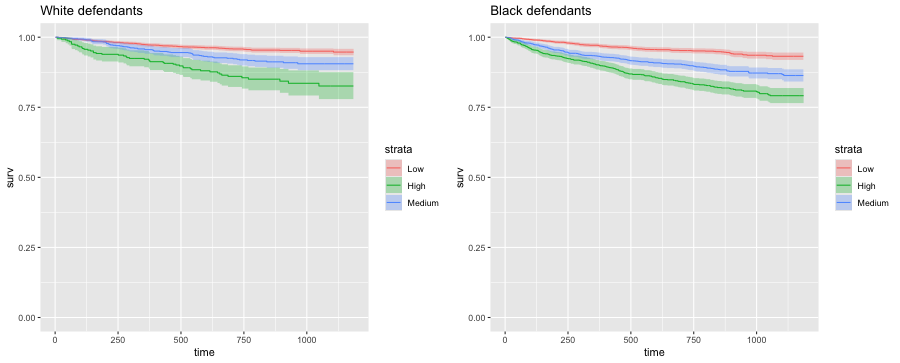

In [49]:
%%R -w 900 -h 363 -u px
white <- filter(violent_data, race == "Caucasian")
white_fit <- survfit(vf, data=white)

black <- filter(violent_data, race == "African-American")
black_fit <- survfit(vf, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)

## Directions of the Racial Bias

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [50]:
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
from csv import DictReader

people = []
with open("./cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]

In [51]:
print("All defendants")
table(list(recid), list(surv))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [52]:
print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

Total pop: 7214


In [53]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
                                                statistics.stdev(map(lambda i: i.lifetime, pop))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


Overall, the false positive rate is 32.35%.

In [54]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51


That number is higher for African Americans at 44.85%.

In [55]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recid)), list(filter(is_white, surv)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


And lower for whites at 23.45%.

In [56]:
44.85 / 23.45

1.9125799573560769

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [57]:
47.72 / 27.99

1.7048946052161487

In [58]:
hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [59]:
hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72


## Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [60]:
vpeople = []
with open("./cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]

In [61]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	4121	1597	0.89
Recidivated	347	389	0.11
Total: 6454.00
False positive rate: 27.93
False negative rate: 47.15
Specificity: 0.72
Sensitivity: 0.53
Prevalence: 0.11
PPV: 0.20
NPV: 0.92
LR+: 1.89
LR-: 0.65


Even moreso for Black defendants.

In [62]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	1692	1043	0.86
Recidivated	170	273	0.14
Total: 3178.00
False positive rate: 38.14
False negative rate: 38.37
Specificity: 0.62
Sensitivity: 0.62
Prevalence: 0.14
PPV: 0.21
NPV: 0.91
LR+: 1.62
LR-: 0.62


In [63]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

White defendants
           	Low	High
Survived   	1679	380	0.91
Recidivated	129	77	0.09
Total: 2265.00
False positive rate: 18.46
False negative rate: 62.62
Specificity: 0.82
Sensitivity: 0.37
Prevalence: 0.09
PPV: 0.17
NPV: 0.93
LR+: 2.03
LR-: 0.77


Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [64]:
38.14 / 18.46

2.066088840736728

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [65]:
62.62 / 38.37

1.63200416992442

## Gender differences in Compas scores

In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

In [66]:
%%R

female <- filter(data, sex == "Female")
male   <- filter(data, sex == "Male")
male_fit <- survfit(f, data=male)
female_fit <- survfit(f, data=female)

In [67]:
%%R
summary(male_fit, times=c(730))

Call: survfit(formula = f, data = male)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    7.30e+02     2.13e+03     1.02e+03     7.58e-01     6.67e-03     7.45e-01 
upper 95% CI 
    7.71e-01 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
     730.000      421.000      857.000        0.388        0.013        0.363 
upper 95% CI 
       0.414 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     752.0000     838.0000       0.5352       0.0118       0.5126 
upper 95% CI 
      0.5588 



In [68]:
%%R
summary(female_fit, times=c(730))

Call: survfit(formula = f, data = female)

                score_factor=Low 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     617.0000     194.0000       0.8381       0.0107       0.8174 
upper 95% CI 
      0.8593 

                score_factor=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000      84.0000     115.0000       0.5252       0.0325       0.4652 
upper 95% CI 
      0.5929 

                score_factor=Medium 
        time       n.risk      n.event     survival      std.err lower 95% CI 
    730.0000     227.0000     184.0000       0.6586       0.0206       0.6194 
upper 95% CI 
      0.7003 



Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


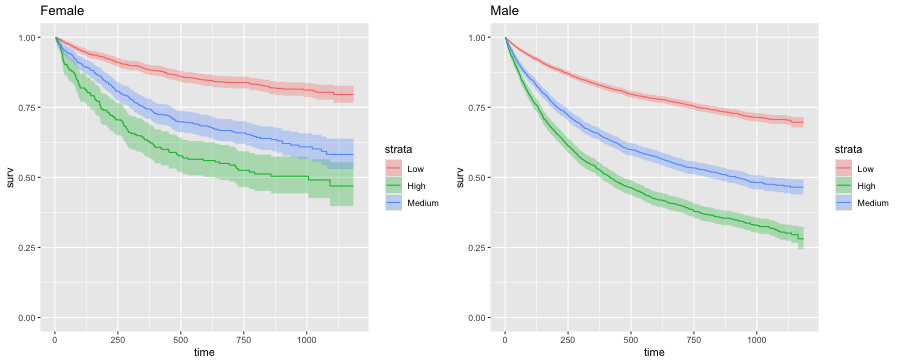

In [69]:
%%R -w 900 -h 363 -u px
grid.arrange(plotty(female_fit, "Female"), plotty(male_fit, "Male"),ncol=2)

As these plots show, the Compas score treats a High risk women the same as a Medium risk man.

## Logistic Regression with ℓ₂ Regularization

We now implement a logistic regression classifier with L2 (ridge) regularization, trained using batch gradient descent. This serves as a transparent, interpretable baseline to compare against the proprietary COMPAS score.

The model minimizes the regularized cross-entropy loss:

$$\mathcal{L}(\mathbf{w}) = -\frac{1}{n}\sum_{i=1}^{n}\left[y_i \log(\sigma(\mathbf{w}^T\mathbf{x}_i)) + (1-y_i)\log(1-\sigma(\mathbf{w}^T\mathbf{x}_i))\right] + \frac{\lambda}{2}\|\mathbf{w}\|_2^2$$

where $\sigma(z) = 1/(1+e^{-z})$ is the sigmoid function and $\lambda$ is the regularization strength.


In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess data using the same pipeline as the R analysis
raw_data = pd.read_csv("./compas-scores-two-years.csv")

# Apply the same filters as the ProPublica analysis
df = raw_data[
    (raw_data['days_b_screening_arrest'] <= 30) &
    (raw_data['days_b_screening_arrest'] >= -30) &
    (raw_data['is_recid'] != -1) &
    (raw_data['c_charge_degree'] != 'O') &
    (raw_data['score_text'] != 'N/A')
].copy()

print(f"Filtered dataset size: {len(df)} rows")

# Select features for the model
# Categorical features will be one-hot encoded
categorical_features = ['age_cat', 'sex', 'c_charge_degree']
numerical_features = ['priors_count', 'age']

# Create feature matrix with one-hot encoding
X_cat = pd.get_dummies(df[categorical_features], drop_first=True)
X_num = df[numerical_features].copy()

# Combine features
X = pd.concat([X_num, X_cat], axis=1)
y = df['two_year_recid'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Features: {list(X.columns)}")


Filtered dataset size: 6172 rows
Feature matrix shape: (6172, 6)
Features: ['priors_count', 'age', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'sex_Male', 'c_charge_degree_M']


In [71]:
# Train/validation/test split with stratification
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Recidivism rate - Train: {y_train.mean():.3f}, Val: {y_val.mean():.3f}, Test: {y_test.mean():.3f}")

# Standardize numerical features (important for gradient descent convergence)
scaler = StandardScaler()
feature_names = list(X.columns)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Training set: 3702 samples
Validation set: 1235 samples
Test set: 1235 samples
Recidivism rate - Train: 0.455, Val: 0.455, Test: 0.455


In [72]:
class LogisticRegressionL2:
    """
    Logistic Regression with L2 regularization, trained via batch gradient descent.
    
    Implements the regularized cross-entropy loss:
    L(w) = -1/n * sum[y*log(sigmoid(w'x)) + (1-y)*log(1-sigmoid(w'x))] + (lambda/2)*||w||^2
    """
    
    def __init__(self, learning_rate=0.1, reg_lambda=0.01, max_iters=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.max_iters = max_iters
        self.tol = tol
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def _sigmoid(self, z):
        """Numerically stable sigmoid function."""
        return np.where(z >= 0, 
                        1 / (1 + np.exp(-z)), 
                        np.exp(z) / (1 + np.exp(z)))
    
    def _compute_loss(self, X, y):
        """Compute regularized cross-entropy loss."""
        n = len(y)
        z = X @ self.weights + self.bias
        probs = self._sigmoid(z)
        
        # Clip probabilities to avoid log(0)
        eps = 1e-15
        probs = np.clip(probs, eps, 1 - eps)
        
        # Cross-entropy loss
        ce_loss = -np.mean(y * np.log(probs) + (1 - y) * np.log(1 - probs))
        
        # L2 regularization term (not applied to bias)
        l2_reg = (self.reg_lambda / 2) * np.sum(self.weights ** 2)
        
        return ce_loss + l2_reg
    
    def fit(self, X, y, X_val=None, y_val=None, verbose=True):
        """
        Train the model using batch gradient descent.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        y : array-like of shape (n_samples,)
        X_val, y_val : optional validation data for monitoring
        verbose : bool, print progress every 100 iterations
        """
        n_samples, n_features = X.shape
        
        # Initialize weights
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        self.loss_history = []
        self.val_loss_history = []
        
        for i in range(self.max_iters):
            # Forward pass
            z = X @ self.weights + self.bias
            probs = self._sigmoid(z)
            
            # Compute gradients
            error = probs - y
            grad_weights = (1 / n_samples) * (X.T @ error) + self.reg_lambda * self.weights
            grad_bias = np.mean(error)
            
            # Update weights
            self.weights -= self.learning_rate * grad_weights
            self.bias -= self.learning_rate * grad_bias
            
            # Track loss
            train_loss = self._compute_loss(X, y)
            self.loss_history.append(train_loss)
            
            if X_val is not None:
                val_loss = self._compute_loss(X_val, y_val)
                self.val_loss_history.append(val_loss)
            
            # Check convergence
            if i > 0 and abs(self.loss_history[-2] - self.loss_history[-1]) < self.tol:
                if verbose:
                    print(f"Converged at iteration {i}")
                break
            
            if verbose and (i + 1) % 100 == 0:
                msg = f"Iter {i+1}: Train Loss = {train_loss:.6f}"
                if X_val is not None:
                    msg += f", Val Loss = {val_loss:.6f}"
                print(msg)
        
        return self
    
    def predict_proba(self, X):
        """Return probability of class 1."""
        z = X @ self.weights + self.bias
        return self._sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Return binary predictions."""
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def get_coefficients(self):
        """Return weights and bias."""
        return self.weights, self.bias


In [73]:
# Train logistic regression with L2 regularization
model = LogisticRegressionL2(
    learning_rate=0.5,
    reg_lambda=0.01,
    max_iters=1000,
    tol=1e-7
)

model.fit(X_train_scaled, y_train, X_val_scaled, y_val, verbose=True)

print(f"\nTraining completed in {len(model.loss_history)} iterations")
print(f"Final training loss: {model.loss_history[-1]:.6f}")
print(f"Final validation loss: {model.val_loss_history[-1]:.6f}")


Iter 100: Train Loss = 0.613221, Val Loss = 0.609639
Iter 200: Train Loss = 0.613103, Val Loss = 0.610016
Converged at iteration 213

Training completed in 214 iterations
Final training loss: 0.613102
Final validation loss: 0.610038


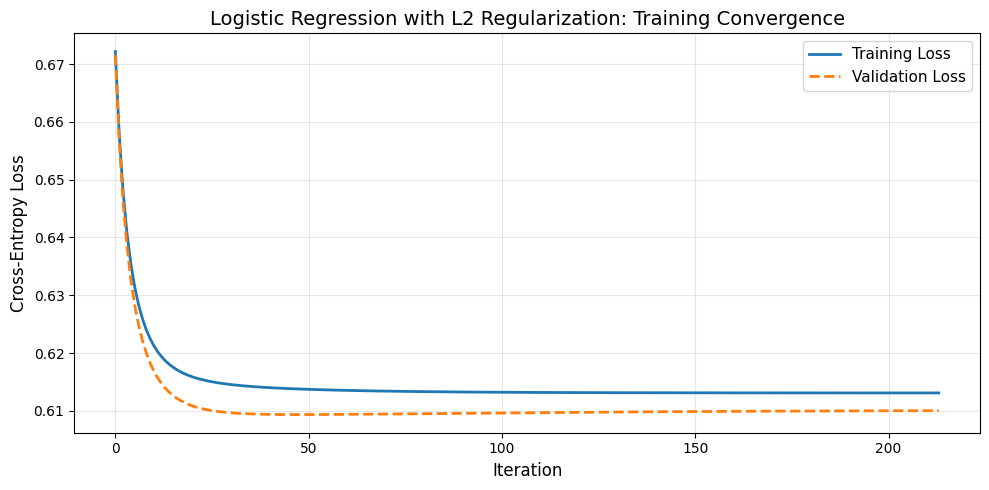

In [74]:
# Plot training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(model.loss_history, label='Training Loss', linewidth=2)
ax.plot(model.val_loss_history, label='Validation Loss', linewidth=2, linestyle='--')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax.set_title('Logistic Regression with L2 Regularization: Training Convergence', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [75]:
# Display learned coefficients (interpretable weights)
weights, bias = model.get_coefficients()

print("Logistic Regression Coefficients (L2 Regularized)")
print("=" * 55)
print(f"{'Feature':<30} {'Coefficient':>12} {'Odds Ratio':>12}")
print("-" * 55)

# Sort by absolute value of coefficient
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': weights,
    'Odds Ratio': np.exp(weights)
}).sort_values('Coefficient', key=abs, ascending=False)

for _, row in coef_df.iterrows():
    print(f"{row['Feature']:<30} {row['Coefficient']:>12.4f} {row['Odds Ratio']:>12.4f}")

print("-" * 55)
print(f"{'Intercept (bias)':<30} {bias:>12.4f}")
print("\nNote: Coefficients are for standardized features.")
print("Positive coefficients increase the probability of recidivism.")


Logistic Regression Coefficients (L2 Regularized)
Feature                         Coefficient   Odds Ratio
-------------------------------------------------------
priors_count                         0.7118       2.0376
age                                 -0.5298       0.5887
sex_Male                             0.1412       1.1517
age_cat_Less than 25                 0.1323       1.1415
c_charge_degree_M                   -0.1260       0.8816
age_cat_Greater than 45              0.1244       1.1325
-------------------------------------------------------
Intercept (bias)                    -0.1867

Note: Coefficients are for standardized features.
Positive coefficients increase the probability of recidivism.


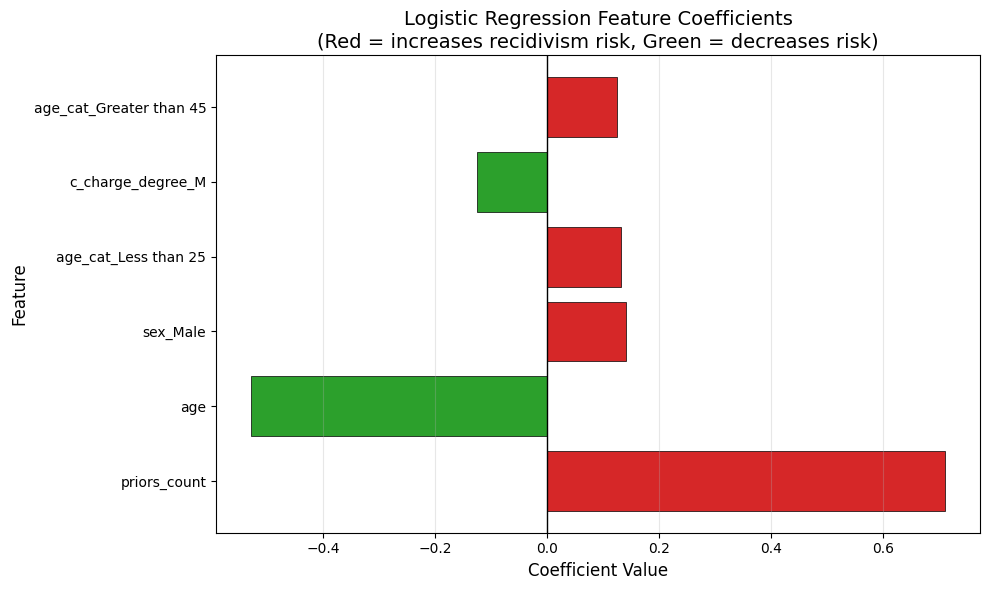

In [76]:
# Visualize feature coefficients
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#d62728' if c > 0 else '#2ca02c' for c in coef_df['Coefficient']]
bars = ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='black', linewidth=0.5)

ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Logistic Regression Feature Coefficients\n(Red = increases recidivism risk, Green = decreases risk)', fontsize=14)
ax.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## Feedforward Neural Network

We implement a small fully connected neural network with 1-2 hidden layers and ReLU activations, trained with backpropagation and cross-entropy loss. This allows us to capture potential nonlinear relationships in the data while still being interpretable through feature importance analysis.

The network architecture:
- Input layer: 6 features (standardized)
- Hidden layer 1: 32 neurons with ReLU activation
- Hidden layer 2: 16 neurons with ReLU activation
- Output layer: 1 neuron with sigmoid activation (probability of recidivism)


In [77]:
class NeuralNetwork:
    """
    Feedforward Neural Network with ReLU activations, trained via backpropagation.
    
    Uses cross-entropy loss for binary classification:
    L = -1/n * sum[y*log(p) + (1-y)*log(1-p)]
    """
    
    def __init__(self, layer_sizes, learning_rate=0.01, reg_lambda=0.001, max_iters=1000):
        """
        Parameters:
        -----------
        layer_sizes : list of int
            Number of neurons in each layer, including input and output.
            e.g., [6, 32, 16, 1] for input=6, two hidden layers of 32 and 16, output=1
        """
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.max_iters = max_iters
        self.weights = []
        self.biases = []
        self.loss_history = []
        self.val_loss_history = []
        
        # Initialize weights using He initialization (good for ReLU)
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def _relu(self, z):
        """ReLU activation function."""
        return np.maximum(0, z)
    
    def _relu_derivative(self, z):
        """Derivative of ReLU."""
        return (z > 0).astype(float)
    
    def _sigmoid(self, z):
        """Numerically stable sigmoid function."""
        return np.where(z >= 0, 
                        1 / (1 + np.exp(-z)), 
                        np.exp(z) / (1 + np.exp(z)))
    
    def _forward(self, X):
        """Forward pass through the network."""
        self.activations = [X]
        self.z_values = []
        
        current = X
        for i in range(len(self.weights) - 1):
            z = current @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            current = self._relu(z)
            self.activations.append(current)
        
        # Output layer with sigmoid
        z = current @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z)
        output = self._sigmoid(z)
        self.activations.append(output)
        
        return output
    
    def _compute_loss(self, y_true, y_pred):
        """Compute cross-entropy loss with L2 regularization."""
        eps = 1e-15
        y_pred = np.clip(y_pred, eps, 1 - eps)
        ce_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # L2 regularization
        l2_reg = 0
        for w in self.weights:
            l2_reg += np.sum(w ** 2)
        l2_reg *= self.reg_lambda / 2
        
        return ce_loss + l2_reg
    
    def _backward(self, X, y):
        """Backpropagation to compute gradients."""
        m = X.shape[0]
        y = y.reshape(-1, 1)
        
        # Output layer gradient (derivative of cross-entropy with sigmoid)
        delta = self.activations[-1] - y
        
        grad_weights = []
        grad_biases = []
        
        # Backpropagate through layers
        for i in range(len(self.weights) - 1, -1, -1):
            # Gradient for weights and biases
            gw = (self.activations[i].T @ delta) / m + self.reg_lambda * self.weights[i]
            gb = np.mean(delta, axis=0, keepdims=True)
            grad_weights.insert(0, gw)
            grad_biases.insert(0, gb)
            
            # Propagate delta to previous layer (if not at input)
            if i > 0:
                delta = (delta @ self.weights[i].T) * self._relu_derivative(self.z_values[i-1])
        
        return grad_weights, grad_biases
    
    def fit(self, X, y, X_val=None, y_val=None, verbose=True):
        """Train the network using mini-batch gradient descent."""
        y = y.reshape(-1, 1)
        batch_size = 64
        
        for epoch in range(self.max_iters):
            # Shuffle data
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            # Mini-batch training
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Forward pass
                _ = self._forward(X_batch)
                
                # Backward pass
                grad_w, grad_b = self._backward(X_batch, y_batch)
                
                # Update weights
                for j in range(len(self.weights)):
                    self.weights[j] -= self.learning_rate * grad_w[j]
                    self.biases[j] -= self.learning_rate * grad_b[j]
            
            # Compute epoch loss
            train_pred = self._forward(X)
            train_loss = self._compute_loss(y, train_pred)
            self.loss_history.append(train_loss)
            
            if X_val is not None:
                val_pred = self._forward(X_val)
                val_loss = self._compute_loss(y_val.reshape(-1, 1), val_pred)
                self.val_loss_history.append(val_loss)
            
            if verbose and (epoch + 1) % 50 == 0:
                msg = f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}"
                if X_val is not None:
                    msg += f", Val Loss = {val_loss:.6f}"
                print(msg)
        
        return self
    
    def predict_proba(self, X):
        """Return probability of class 1."""
        return self._forward(X).flatten()
    
    def predict(self, X, threshold=0.5):
        """Return binary predictions."""
        return (self.predict_proba(X) >= threshold).astype(int)


In [78]:
# Train neural network with 2 hidden layers
n_features = X_train_scaled.shape[1]
nn_model = NeuralNetwork(
    layer_sizes=[n_features, 32, 16, 1],  # Input -> 32 -> 16 -> Output
    learning_rate=0.05,
    reg_lambda=0.001,
    max_iters=200
)

nn_model.fit(X_train_scaled, y_train, X_val_scaled, y_val, verbose=True)

print(f"\nTraining completed in {len(nn_model.loss_history)} epochs")
print(f"Final training loss: {nn_model.loss_history[-1]:.6f}")
print(f"Final validation loss: {nn_model.val_loss_history[-1]:.6f}")


Epoch 50: Train Loss = 0.627643, Val Loss = 0.632353
Epoch 100: Train Loss = 0.618935, Val Loss = 0.626488
Epoch 150: Train Loss = 0.612037, Val Loss = 0.618805
Epoch 200: Train Loss = 0.611344, Val Loss = 0.621586

Training completed in 200 epochs
Final training loss: 0.611344
Final validation loss: 0.621586


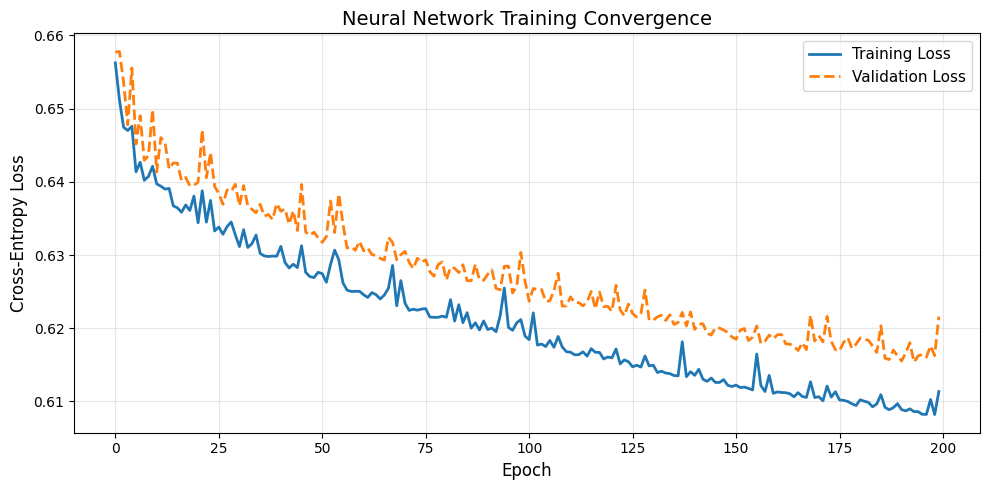


Neural Network Test Set Metrics:
----------------------------------------
Accuracy       : 0.6891
Precision      : 0.6648
Recall         : 0.6388
F1 Score       : 0.6515
AUC-ROC        : 0.7308


In [79]:
# Plot neural network training curves
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(nn_model.loss_history, label='Training Loss', linewidth=2)
ax.plot(nn_model.val_loss_history, label='Validation Loss', linewidth=2, linestyle='--')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Cross-Entropy Loss', fontsize=12)
ax.set_title('Neural Network Training Convergence', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Import metrics for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate neural network on test set
nn_pred = nn_model.predict(X_test_scaled)
nn_proba = nn_model.predict_proba(X_test_scaled)

nn_test_metrics = {
    'Accuracy': accuracy_score(y_test, nn_pred),
    'Precision': precision_score(y_test, nn_pred),
    'Recall': recall_score(y_test, nn_pred),
    'F1 Score': f1_score(y_test, nn_pred),
    'AUC-ROC': roc_auc_score(y_test, nn_proba)
}

print("\nNeural Network Test Set Metrics:")
print("-" * 40)
for name, value in nn_test_metrics.items():
    print(f"{name:15s}: {value:.4f}")


In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_predictions(y_true, y_pred, y_proba, model_name=""):
    """Compute classification metrics from predictions."""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_proba)
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) * 100
    fnr = fn / (fn + tp) * 100
    
    return metrics, (tn, fp, fn, tp), fpr, fnr

def evaluate_model(model, X, y, dataset_name=""):
    """Compute classification metrics for a model."""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    return evaluate_predictions(y, y_pred, y_proba, dataset_name)

# Evaluate L2 Logistic Regression on test set
test_metrics, (lr_tn, lr_fp, lr_fn, lr_tp), lr_fpr, lr_fnr = evaluate_model(model, X_test_scaled, y_test, "L2 Logistic Regression")

print("=" * 75)
print("TEST SET METRICS AND CONFUSION MATRICES - ALL MODELS")
print("=" * 75)

# L2 Logistic Regression
print("\n📊 L2 LOGISTIC REGRESSION")
print("-" * 75)
print(f"{'Metric':<15} {'Value':>10}")
print("-" * 30)
for name, value in test_metrics.items():
    print(f"{name:<15} {value:>10.4f}")
print(f"\nConfusion Matrix:          FPR: {lr_fpr:.2f}%  |  FNR: {lr_fnr:.2f}%")
print(f"              Predicted")
print(f"              No    Yes")
print(f"Actual No    {lr_tn:4d}  {lr_fp:4d}")
print(f"Actual Yes   {lr_fn:4d}  {lr_tp:4d}")

# Continue evaluation for Neural Network and COMPAS
# Get COMPAS predictions for test set
test_indices = X_test.index
df_test_eval = df.loc[test_indices].copy()
compas_high_eval = (df_test_eval['score_text'] != 'Low').astype(int).values
compas_decile_eval = df_test_eval['decile_score'].values

# Neural Network evaluation (if trained)
try:
    nn_pred_eval = nn_model.predict(X_test_scaled)
    nn_proba_eval = nn_model.predict_proba(X_test_scaled)
    nn_metrics, (nn_tn, nn_fp, nn_fn, nn_tp), nn_fpr, nn_fnr = evaluate_predictions(
        y_test, nn_pred_eval, nn_proba_eval, "Neural Network")
    
    print("\n📊 NEURAL NETWORK (2 Hidden Layers)")
    print("-" * 75)
    print(f"{'Metric':<15} {'Value':>10}")
    print("-" * 30)
    for name, value in nn_metrics.items():
        print(f"{name:<15} {value:>10.4f}")
    print(f"\nConfusion Matrix:          FPR: {nn_fpr:.2f}%  |  FNR: {nn_fnr:.2f}%")
    print(f"              Predicted")
    print(f"              No    Yes")
    print(f"Actual No    {nn_tn:4d}  {nn_fp:4d}")
    print(f"Actual Yes   {nn_fn:4d}  {nn_tp:4d}")
    nn_trained = True
except:
    print("\n📊 NEURAL NETWORK: Not yet trained - run neural network cells first")
    nn_trained = False

# COMPAS evaluation
compas_metrics, (compas_tn, compas_fp, compas_fn, compas_tp), compas_fpr, compas_fnr = evaluate_predictions(
    y_test, compas_high_eval, compas_decile_eval / 10, "COMPAS")

print("\n📊 COMPAS (High/Medium vs Low)")
print("-" * 75)
print(f"{'Metric':<15} {'Value':>10}")
print("-" * 30)
for name, value in compas_metrics.items():
    print(f"{name:<15} {value:>10.4f}")
print(f"\nConfusion Matrix:          FPR: {compas_fpr:.2f}%  |  FNR: {compas_fnr:.2f}%")
print(f"              Predicted")
print(f"              No    Yes")
print(f"Actual No    {compas_tn:4d}  {compas_fp:4d}")
print(f"Actual Yes   {compas_fn:4d}  {compas_tp:4d}")

# Summary comparison table
print("\n" + "=" * 75)
print("COMPARISON SUMMARY TABLE")
print("=" * 75)
print(f"{'Model':<25} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10} {'AUC':>10}")
print("-" * 75)
print(f"{'L2 Logistic Regression':<25} {test_metrics['Accuracy']:>10.4f} {test_metrics['Precision']:>10.4f} {test_metrics['Recall']:>10.4f} {test_metrics['F1 Score']:>10.4f} {test_metrics['AUC-ROC']:>10.4f}")
if nn_trained:
    print(f"{'Neural Network':<25} {nn_metrics['Accuracy']:>10.4f} {nn_metrics['Precision']:>10.4f} {nn_metrics['Recall']:>10.4f} {nn_metrics['F1 Score']:>10.4f} {nn_metrics['AUC-ROC']:>10.4f}")
print(f"{'COMPAS':<25} {compas_metrics['Accuracy']:>10.4f} {compas_metrics['Precision']:>10.4f} {compas_metrics['Recall']:>10.4f} {compas_metrics['F1 Score']:>10.4f} {compas_metrics['AUC-ROC']:>10.4f}")


TEST SET METRICS AND CONFUSION MATRICES - ALL MODELS

📊 L2 LOGISTIC REGRESSION
---------------------------------------------------------------------------
Metric               Value
------------------------------
Accuracy            0.6802
Precision           0.6736
Recall              0.5765
F1 Score            0.6213
AUC-ROC             0.7281

Confusion Matrix:          FPR: 23.33%  |  FNR: 42.35%
              Predicted
              No    Yes
Actual No     516   157
Actual Yes    238   324

📊 NEURAL NETWORK (2 Hidden Layers)
---------------------------------------------------------------------------
Metric               Value
------------------------------
Accuracy            0.6891
Precision           0.6648
Recall              0.6388
F1 Score            0.6515
AUC-ROC             0.7308

Confusion Matrix:          FPR: 26.89%  |  FNR: 36.12%
              Predicted
              No    Yes
Actual No     492   181
Actual Yes    203   359

📊 COMPAS (High/Medium vs Low)
------------

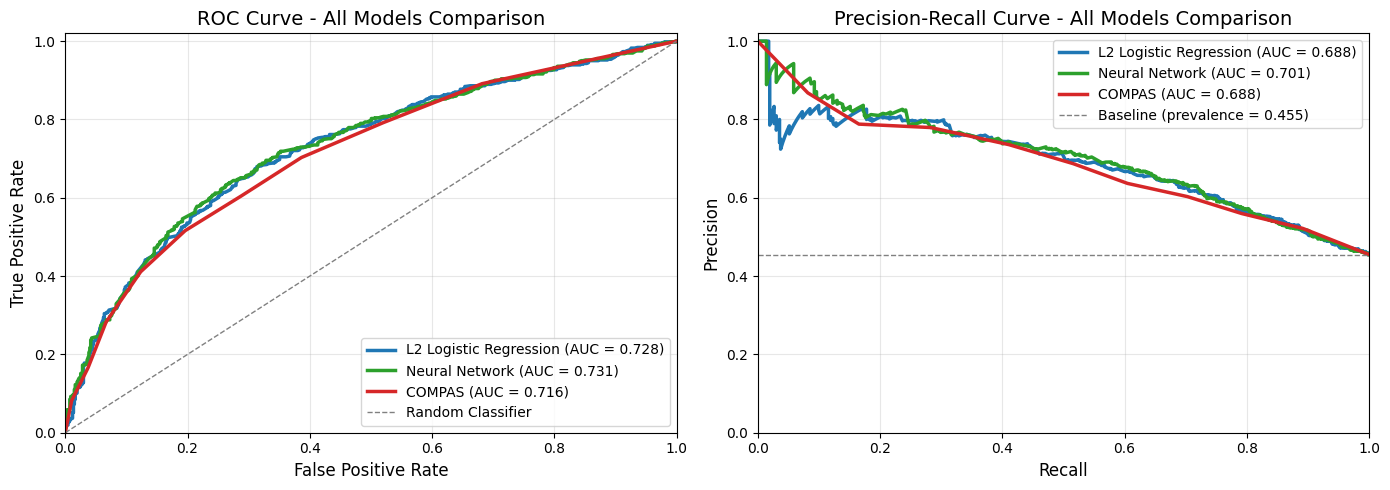


SUMMARY: ROC-AUC and PR-AUC for All Models
Model                               ROC-AUC       PR-AUC
------------------------------------------------------------
L2 Logistic Regression               0.7281       0.6884
Neural Network                       0.7308       0.7011
COMPAS                               0.7165       0.6877


In [81]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Get predictions for all models
# L2 Logistic Regression
lr_proba_test = model.predict_proba(X_test_scaled)
lr_pred_test = model.predict(X_test_scaled)

# Get COMPAS data for test set
test_indices = X_test.index
df_test_temp = df.loc[test_indices].copy()
compas_decile_test = df_test_temp['decile_score'].values
compas_high_test = (df_test_temp['score_text'] != 'Low').astype(int).values

# Neural Network (check if available)
try:
    nn_proba_test = nn_model.predict_proba(X_test_scaled)
    nn_pred_test = nn_model.predict(X_test_scaled)
    nn_available_here = True
except:
    nn_available_here = False

# Compute ROC curves for all models
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba_test)
fpr_compas, tpr_compas, _ = roc_curve(y_test, compas_decile_test)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_compas = auc(fpr_compas, tpr_compas)

# Compute PR curves for all models  
precision_lr, recall_lr, _ = precision_recall_curve(y_test, lr_proba_test)
precision_compas, recall_compas, _ = precision_recall_curve(y_test, compas_decile_test)
pr_auc_lr = auc(recall_lr, precision_lr)
pr_auc_compas = auc(recall_compas, precision_compas)

if nn_available_here:
    fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_proba_test)
    precision_nn, recall_nn, _ = precision_recall_curve(y_test, nn_proba_test)
    roc_auc_nn = auc(fpr_nn, tpr_nn)
    pr_auc_nn = auc(recall_nn, precision_nn)

# Plot ROC and Precision-Recall curves for ALL models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve - All Models
axes[0].plot(fpr_lr, tpr_lr, color='#1f77b4', linewidth=2.5, 
             label=f'L2 Logistic Regression (AUC = {roc_auc_lr:.3f})')
if nn_available_here:
    axes[0].plot(fpr_nn, tpr_nn, color='#2ca02c', linewidth=2.5, 
                 label=f'Neural Network (AUC = {roc_auc_nn:.3f})')
axes[0].plot(fpr_compas, tpr_compas, color='#d62728', linewidth=2.5, 
             label=f'COMPAS (AUC = {roc_auc_compas:.3f})')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - All Models Comparison', fontsize=14)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1.02])

# Precision-Recall Curve - All Models
axes[1].plot(recall_lr, precision_lr, color='#1f77b4', linewidth=2.5, 
             label=f'L2 Logistic Regression (AUC = {pr_auc_lr:.3f})')
if nn_available_here:
    axes[1].plot(recall_nn, precision_nn, color='#2ca02c', linewidth=2.5, 
                 label=f'Neural Network (AUC = {pr_auc_nn:.3f})')
axes[1].plot(recall_compas, precision_compas, color='#d62728', linewidth=2.5, 
             label=f'COMPAS (AUC = {pr_auc_compas:.3f})')
axes[1].axhline(y=y_test.mean(), color='gray', linestyle='--', linewidth=1, 
                label=f'Baseline (prevalence = {y_test.mean():.3f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - All Models Comparison', fontsize=14)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.02])

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "=" * 60)
print("SUMMARY: ROC-AUC and PR-AUC for All Models")
print("=" * 60)
print(f"{'Model':<30} {'ROC-AUC':>12} {'PR-AUC':>12}")
print("-" * 60)
print(f"{'L2 Logistic Regression':<30} {roc_auc_lr:>12.4f} {pr_auc_lr:>12.4f}")
if nn_available_here:
    print(f"{'Neural Network':<30} {roc_auc_nn:>12.4f} {pr_auc_nn:>12.4f}")
print(f"{'COMPAS':<30} {roc_auc_compas:>12.4f} {pr_auc_compas:>12.4f}")


In [82]:
# Get COMPAS scores for comparison (using same test set indices)
test_indices = X_test.index
df_test = df.loc[test_indices].copy()

# COMPAS binary prediction (High/Medium vs Low)
compas_high = (df_test['score_text'] != 'Low').astype(int).values
compas_decile = df_test['decile_score'].values

# Our model predictions
lr_pred = model.predict(X_test_scaled)
lr_proba = model.predict_proba(X_test_scaled)

# Neural network predictions (will be populated after NN training)
try:
    nn_pred = nn_model.predict(X_test_scaled)
    nn_proba = nn_model.predict_proba(X_test_scaled)
    nn_available = True
except:
    nn_available = False

print("Performance Comparison: All Models vs COMPAS")
print("=" * 60)

# Logistic Regression metrics
print("\n📊 L2 Logistic Regression:")
print(f"   Accuracy:  {accuracy_score(y_test, lr_pred):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test, lr_proba):.4f}")
print(f"   Precision: {precision_score(y_test, lr_pred):.4f}")
print(f"   Recall:    {recall_score(y_test, lr_pred):.4f}")

# Neural Network metrics
if nn_available:
    print("\n📊 Neural Network (2 hidden layers):")
    print(f"   Accuracy:  {accuracy_score(y_test, nn_pred):.4f}")
    print(f"   AUC-ROC:   {roc_auc_score(y_test, nn_proba):.4f}")
    print(f"   Precision: {precision_score(y_test, nn_pred):.4f}")
    print(f"   Recall:    {recall_score(y_test, nn_pred):.4f}")

# COMPAS metrics (using High/Medium as positive)
print("\n📊 COMPAS (High/Medium vs Low threshold):")
print(f"   Accuracy:  {accuracy_score(y_test, compas_high):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test, compas_decile / 10):.4f}")
print(f"   Precision: {precision_score(y_test, compas_high):.4f}")
print(f"   Recall:    {recall_score(y_test, compas_high):.4f}")


Performance Comparison: All Models vs COMPAS

📊 L2 Logistic Regression:
   Accuracy:  0.6802
   AUC-ROC:   0.7281
   Precision: 0.6736
   Recall:    0.5765

📊 Neural Network (2 hidden layers):
   Accuracy:  0.6891
   AUC-ROC:   0.7308
   Precision: 0.6648
   Recall:    0.6388

📊 COMPAS (High/Medium vs Low threshold):
   Accuracy:  0.6632
   AUC-ROC:   0.7165
   Precision: 0.6367
   Recall:    0.6050


### Group-wise Fairness Analysis

Following the project plan, we analyze false positive and false negative rates across demographic groups to assess fairness of our logistic regression model compared to COMPAS.


In [83]:
def compute_group_metrics(y_true, y_pred, group_mask, group_name):
    """Compute metrics for a demographic subgroup."""
    y_true_g = y_true[group_mask]
    y_pred_g = y_pred[group_mask]
    
    cm = confusion_matrix(y_true_g, y_pred_g)
    tn, fp, fn, tp = cm.ravel()
    
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return {
        'Group': group_name,
        'N': len(y_true_g),
        'Accuracy': accuracy,
        'FPR': fpr,
        'FNR': fnr,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    }

# Get race data for test set
race_test = df_test['race'].values

# Analyze for major demographic groups
groups = ['African-American', 'Caucasian']

print("Group-wise Fairness Metrics Comparison")
print("=" * 80)

# Logistic Regression
print("\n📊 L2 Logistic Regression Model:")
print("-" * 80)
print(f"{'Group':<20} {'N':>6} {'Accuracy':>10} {'FPR':>10} {'FNR':>10}")
print("-" * 80)

lr_results = []
for group in groups:
    mask = race_test == group
    result = compute_group_metrics(y_test, lr_pred, mask, group)
    lr_results.append(result)
    print(f"{result['Group']:<20} {result['N']:>6} {result['Accuracy']:>10.4f} {result['FPR']*100:>9.2f}% {result['FNR']*100:>9.2f}%")

# Neural Network
if nn_available:
    print("\n📊 Neural Network (2 hidden layers):")
    print("-" * 80)
    print(f"{'Group':<20} {'N':>6} {'Accuracy':>10} {'FPR':>10} {'FNR':>10}")
    print("-" * 80)
    
    nn_results = []
    for group in groups:
        mask = race_test == group
        result = compute_group_metrics(y_test, nn_pred, mask, group)
        nn_results.append(result)
        print(f"{result['Group']:<20} {result['N']:>6} {result['Accuracy']:>10.4f} {result['FPR']*100:>9.2f}% {result['FNR']*100:>9.2f}%")

# COMPAS
print("\n📊 COMPAS (High/Medium vs Low):")
print("-" * 80)
print(f"{'Group':<20} {'N':>6} {'Accuracy':>10} {'FPR':>10} {'FNR':>10}")
print("-" * 80)

compas_results = []
for group in groups:
    mask = race_test == group
    result = compute_group_metrics(y_test, compas_high, mask, group)
    compas_results.append(result)
    print(f"{result['Group']:<20} {result['N']:>6} {result['Accuracy']:>10.4f} {result['FPR']*100:>9.2f}% {result['FNR']*100:>9.2f}%")


Group-wise Fairness Metrics Comparison

📊 L2 Logistic Regression Model:
--------------------------------------------------------------------------------
Group                     N   Accuracy        FPR        FNR
--------------------------------------------------------------------------------
African-American        641     0.6958     30.26%     30.56%
Caucasian               427     0.6534     17.29%     63.35%

📊 Neural Network (2 hidden layers):
--------------------------------------------------------------------------------
Group                     N   Accuracy        FPR        FNR
--------------------------------------------------------------------------------
African-American        641     0.7067     35.53%     23.74%
Caucasian               427     0.6581     20.30%     57.14%

📊 COMPAS (High/Medium vs Low):
--------------------------------------------------------------------------------
Group                     N   Accuracy        FPR        FNR
---------------------------

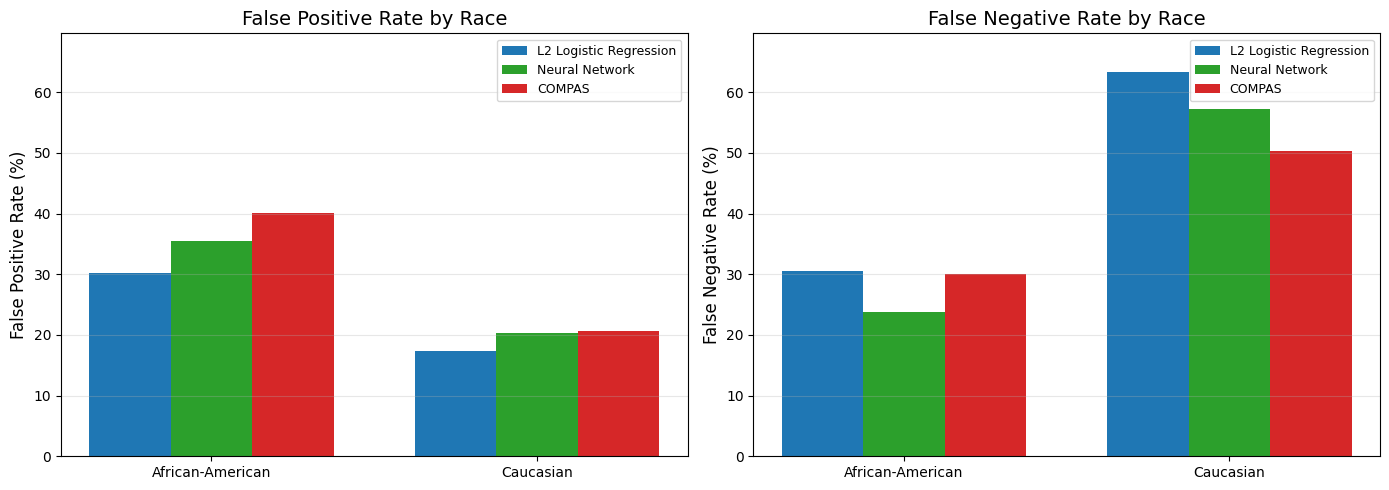


Disparity Analysis (ratio of Black to White FPR):
--------------------------------------------------
L2 Logistic Regression: 1.75x
Neural Network:         1.75x
COMPAS:                 1.94x


In [84]:
# Visualize fairness comparison (all models)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(groups))
n_models = 3 if nn_available else 2
width = 0.25 if nn_available else 0.35

# False Positive Rate comparison
ax1 = axes[0]
lr_fprs = [r['FPR'] * 100 for r in lr_results]
compas_fprs = [r['FPR'] * 100 for r in compas_results]

if nn_available:
    nn_fprs = [r['FPR'] * 100 for r in nn_results]
    bars1 = ax1.bar(x - width, lr_fprs, width, label='L2 Logistic Regression', color='#1f77b4')
    bars_nn = ax1.bar(x, nn_fprs, width, label='Neural Network', color='#2ca02c')
    bars2 = ax1.bar(x + width, compas_fprs, width, label='COMPAS', color='#d62728')
else:
    bars1 = ax1.bar(x - width/2, lr_fprs, width, label='L2 Logistic Regression', color='#1f77b4')
    bars2 = ax1.bar(x + width/2, compas_fprs, width, label='COMPAS', color='#d62728')

ax1.set_ylabel('False Positive Rate (%)', fontsize=12)
ax1.set_title('False Positive Rate by Race', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(groups)
ax1.legend(fontsize=9)
ax1.grid(True, axis='y', alpha=0.3)

# False Negative Rate comparison
ax2 = axes[1]
lr_fnrs = [r['FNR'] * 100 for r in lr_results]
compas_fnrs = [r['FNR'] * 100 for r in compas_results]

if nn_available:
    nn_fnrs = [r['FNR'] * 100 for r in nn_results]
    bars3 = ax2.bar(x - width, lr_fnrs, width, label='L2 Logistic Regression', color='#1f77b4')
    bars_nn2 = ax2.bar(x, nn_fnrs, width, label='Neural Network', color='#2ca02c')
    bars4 = ax2.bar(x + width, compas_fnrs, width, label='COMPAS', color='#d62728')
else:
    bars3 = ax2.bar(x - width/2, lr_fnrs, width, label='L2 Logistic Regression', color='#1f77b4')
    bars4 = ax2.bar(x + width/2, compas_fnrs, width, label='COMPAS', color='#d62728')

ax2.set_ylabel('False Negative Rate (%)', fontsize=12)
ax2.set_title('False Negative Rate by Race', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(groups)
ax2.legend(fontsize=9)
ax2.grid(True, axis='y', alpha=0.3)

# Set consistent y-axis limits for both plots
all_rates = lr_fprs + compas_fprs + lr_fnrs + compas_fnrs
if nn_available:
    all_rates += nn_fprs + nn_fnrs
y_max = max(all_rates) * 1.1  # Add 10% padding
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

# Print disparity ratios
print("\nDisparity Analysis (ratio of Black to White FPR):")
print("-" * 50)
lr_fpr_ratio = lr_results[0]['FPR'] / lr_results[1]['FPR'] if lr_results[1]['FPR'] > 0 else float('inf')
compas_fpr_ratio = compas_results[0]['FPR'] / compas_results[1]['FPR'] if compas_results[1]['FPR'] > 0 else float('inf')
print(f"L2 Logistic Regression: {lr_fpr_ratio:.2f}x")
if nn_available:
    nn_fpr_ratio = nn_results[0]['FPR'] / nn_results[1]['FPR'] if nn_results[1]['FPR'] > 0 else float('inf')
    print(f"Neural Network:         {nn_fpr_ratio:.2f}x")
print(f"COMPAS:                 {compas_fpr_ratio:.2f}x")


### Calibration Analysis

We examine how well-calibrated the predicted probabilities are. A well-calibrated model should have predicted probabilities that match observed frequencies.


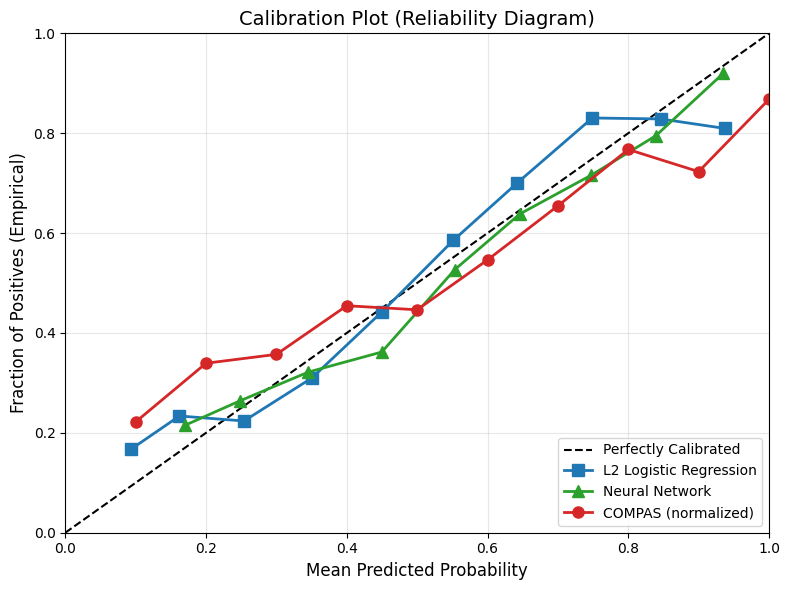

A well-calibrated classifier should follow the diagonal line closely.


In [85]:
from sklearn.calibration import calibration_curve

# Compute calibration curves
prob_true_lr, prob_pred_lr = calibration_curve(y_test, lr_proba, n_bins=10, strategy='uniform')
prob_true_compas, prob_pred_compas = calibration_curve(y_test, compas_decile / 10, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=1.5)
ax.plot(prob_pred_lr, prob_true_lr, 's-', color='#1f77b4', linewidth=2, markersize=8,
        label='L2 Logistic Regression')

# Add Neural Network calibration if available
if nn_available:
    prob_true_nn, prob_pred_nn = calibration_curve(y_test, nn_proba, n_bins=10, strategy='uniform')
    ax.plot(prob_pred_nn, prob_true_nn, '^-', color='#2ca02c', linewidth=2, markersize=8,
            label='Neural Network')

ax.plot(prob_pred_compas, prob_true_compas, 'o-', color='#d62728', linewidth=2, markersize=8,
        label='COMPAS (normalized)')

ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives (Empirical)', fontsize=12)
ax.set_title('Calibration Plot (Reliability Diagram)', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("A well-calibrated classifier should follow the diagonal line closely.")


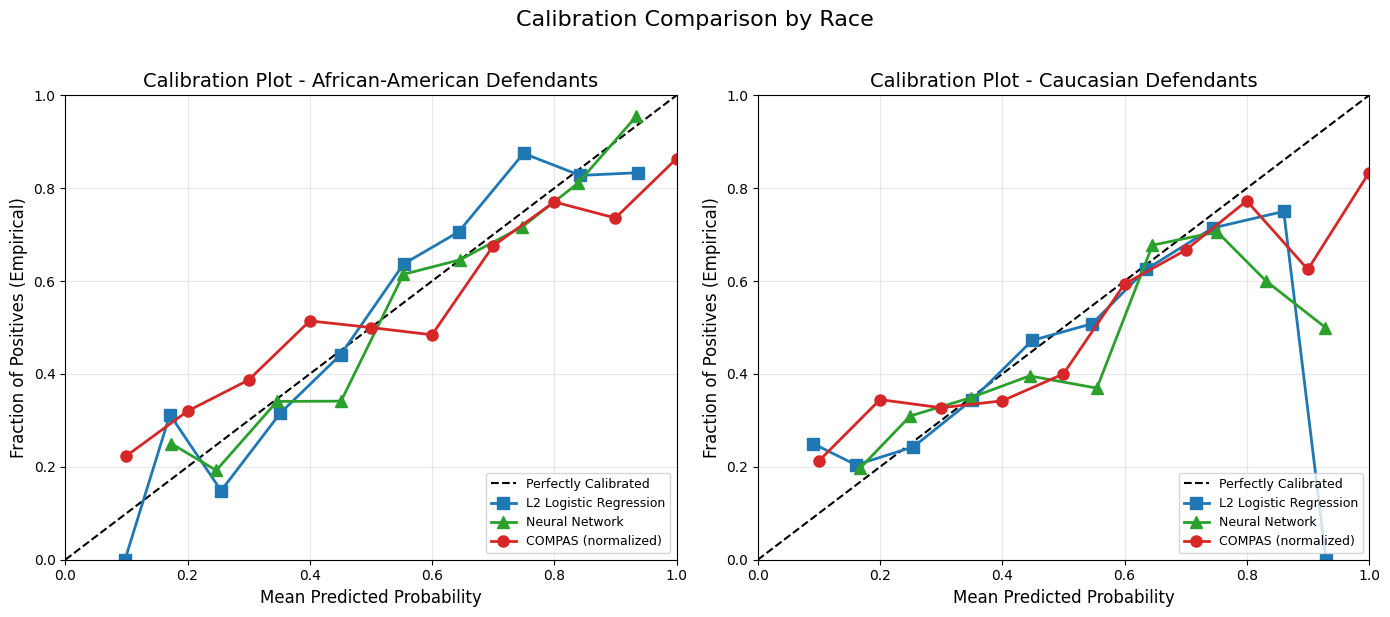


Interpretation:
- A well-calibrated model follows the diagonal line for ALL demographic groups
- Deviations indicate the model is over- or under-confident for that group
- Differences between groups reveal potential calibration bias


In [86]:
# Calibration Plots by Race - Comparing models across demographic groups
# This shows whether models are equally well-calibrated for different racial groups

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

groups = ['African-American', 'Caucasian']
group_colors = {'African-American': '#1f77b4', 'Caucasian': '#ff7f0e'}

for idx, group in enumerate(groups):
    ax = axes[idx]
    mask = race_test == group
    
    # Get predictions for this group
    y_group = y_test[mask]
    lr_proba_group = lr_proba[mask]
    compas_decile_group = compas_decile[mask]
    
    # Plot perfect calibration line
    ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=1.5)
    
    # L2 Logistic Regression calibration for this group
    try:
        prob_true_lr_g, prob_pred_lr_g = calibration_curve(y_group, lr_proba_group, n_bins=10, strategy='uniform')
        ax.plot(prob_pred_lr_g, prob_true_lr_g, 's-', color='#1f77b4', linewidth=2, markersize=8,
                label='L2 Logistic Regression')
    except:
        pass
    
    # Neural Network calibration for this group
    if nn_available:
        try:
            nn_proba_group = nn_proba[mask]
            prob_true_nn_g, prob_pred_nn_g = calibration_curve(y_group, nn_proba_group, n_bins=10, strategy='uniform')
            ax.plot(prob_pred_nn_g, prob_true_nn_g, '^-', color='#2ca02c', linewidth=2, markersize=8,
                    label='Neural Network')
        except:
            pass
    
    # COMPAS calibration for this group
    try:
        prob_true_compas_g, prob_pred_compas_g = calibration_curve(y_group, compas_decile_group / 10, n_bins=10, strategy='uniform')
        ax.plot(prob_pred_compas_g, prob_true_compas_g, 'o-', color='#d62728', linewidth=2, markersize=8,
                label='COMPAS (normalized)')
    except:
        pass
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax.set_ylabel('Fraction of Positives (Empirical)', fontsize=12)
    ax.set_title(f'Calibration Plot - {group} Defendants', fontsize=14)
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.suptitle('Calibration Comparison by Race', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- A well-calibrated model follows the diagonal line for ALL demographic groups")
print("- Deviations indicate the model is over- or under-confident for that group")
print("- Differences between groups reveal potential calibration bias")


In [87]:
# Numerical Calibration Metrics - Closeness to Perfect Calibration
from sklearn.metrics import brier_score_loss

def compute_calibration_metrics(y_true, y_prob, n_bins=10):
    """
    Compute calibration metrics: Brier Score, ECE, and MCE.
    
    - Brier Score: Mean squared error of probabilistic predictions (lower = better)
    - ECE (Expected Calibration Error): Mean absolute deviation from perfect calibration
    - MCE (Maximum Calibration Error): Worst-case deviation from perfect calibration
    """
    y_prob = np.asarray(y_prob).flatten()
    y_true = np.asarray(y_true).flatten()
    
    # Brier Score
    brier = brier_score_loss(y_true, y_prob)
    
    # Manually compute ECE and MCE with proper bin weighting
    bin_edges = np.linspace(0, 1, n_bins + 1)
    
    ece = 0.0
    mce = 0.0
    total_samples = len(y_prob)
    
    for i in range(n_bins):
        # Find samples in this bin
        bin_mask = (y_prob > bin_edges[i]) & (y_prob <= bin_edges[i + 1])
        # Include left edge for first bin
        if i == 0:
            bin_mask = (y_prob >= bin_edges[i]) & (y_prob <= bin_edges[i + 1])
        
        bin_count = np.sum(bin_mask)
        
        if bin_count > 0:
            # Average predicted probability in this bin
            avg_pred = np.mean(y_prob[bin_mask])
            # Fraction of positives (actual probability) in this bin
            avg_true = np.mean(y_true[bin_mask])
            
            # Calibration error for this bin
            bin_error = np.abs(avg_true - avg_pred)
            
            # Weight by fraction of samples in this bin
            bin_weight = bin_count / total_samples
            ece += bin_weight * bin_error
            
            # Track maximum calibration error
            mce = max(mce, bin_error)
    
    return brier, ece, mce

print("=" * 70)
print("CALIBRATION METRICS: Numerical Closeness to Perfect Calibration")
print("=" * 70)
print("\nMetric Definitions:")
print("  • Brier Score: Mean squared error of predictions (lower = better)")
print("  • ECE: Expected Calibration Error - avg deviation from diagonal (lower = better)")
print("  • MCE: Maximum Calibration Error - worst deviation (lower = better)")
print()

# Compute metrics for each model
lr_brier, lr_ece, lr_mce = compute_calibration_metrics(y_test, lr_proba)
compas_brier, compas_ece, compas_mce = compute_calibration_metrics(y_test, compas_decile / 10)

print("-" * 70)
print(f"{'Model':<30} {'Brier Score':>12} {'ECE':>12} {'MCE':>12}")
print("-" * 70)
print(f"{'L2 Logistic Regression':<30} {lr_brier:>12.4f} {lr_ece:>12.4f} {lr_mce:>12.4f}")

if nn_available:
    nn_brier, nn_ece, nn_mce = compute_calibration_metrics(y_test, nn_proba)
    print(f"{'Neural Network':<30} {nn_brier:>12.4f} {nn_ece:>12.4f} {nn_mce:>12.4f}")

print(f"{'COMPAS (normalized)':<30} {compas_brier:>12.4f} {compas_ece:>12.4f} {compas_mce:>12.4f}")
print("-" * 70)

# Determine the best model for each metric
print("\n📊 CALIBRATION RANKINGS (1 = best calibrated):")
print("-" * 70)

models = ['L2 Logistic Regression', 'COMPAS']
brier_scores = [lr_brier, compas_brier]
ece_scores = [lr_ece, compas_ece]
mce_scores = [lr_mce, compas_mce]

if nn_available:
    models.insert(1, 'Neural Network')
    brier_scores.insert(1, nn_brier)
    ece_scores.insert(1, nn_ece)
    mce_scores.insert(1, nn_mce)

# Rank by each metric (lower is better)
brier_rank = np.argsort(brier_scores) + 1
ece_rank = np.argsort(ece_scores) + 1
mce_rank = np.argsort(mce_scores) + 1

print(f"{'Model':<30} {'Brier Rank':>12} {'ECE Rank':>12} {'MCE Rank':>12}")
print("-" * 70)
for i, model_name in enumerate(models):
    print(f"{model_name:<30} {brier_rank[i]:>12} {ece_rank[i]:>12} {mce_rank[i]:>12}")

# Identify overall best
avg_ranks = (brier_rank + ece_rank + mce_rank) / 3
best_idx = np.argmin(avg_ranks)
print("-" * 70)
print(f"\n🏆 BEST CALIBRATED MODEL: {models[best_idx]}")
print(f"   (Lowest average rank across all calibration metrics)")


CALIBRATION METRICS: Numerical Closeness to Perfect Calibration

Metric Definitions:
  • Brier Score: Mean squared error of predictions (lower = better)
  • ECE: Expected Calibration Error - avg deviation from diagonal (lower = better)
  • MCE: Maximum Calibration Error - worst deviation (lower = better)

----------------------------------------------------------------------
Model                           Brier Score          ECE          MCE
----------------------------------------------------------------------
L2 Logistic Regression               0.2103       0.0382       0.1280
Neural Network                       0.2078       0.0334       0.0879
COMPAS (normalized)                  0.2206       0.0884       0.1769
----------------------------------------------------------------------

📊 CALIBRATION RANKINGS (1 = best calibrated):
----------------------------------------------------------------------
Model                            Brier Rank     ECE Rank     MCE Rank
------------

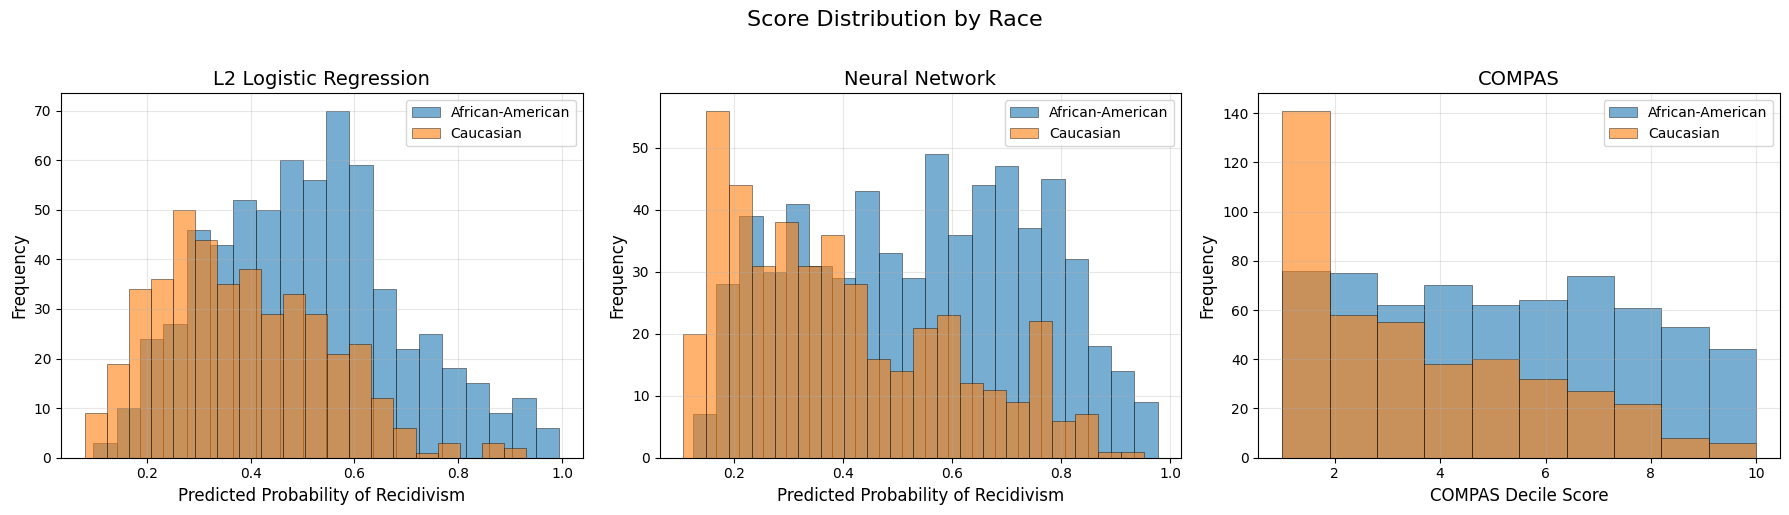

In [88]:
# Score distribution by race (as outlined in project plan)
n_plots = 3 if nn_available else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

# L2 Logistic Regression predicted probabilities
ax1 = axes[0]
for group, color in [('African-American', '#1f77b4'), ('Caucasian', '#ff7f0e')]:
    mask = race_test == group
    ax1.hist(lr_proba[mask], bins=20, alpha=0.6, label=group, color=color, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Predicted Probability of Recidivism', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('L2 Logistic Regression', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Neural Network predicted probabilities
if nn_available:
    ax_nn = axes[1]
    for group, color in [('African-American', '#1f77b4'), ('Caucasian', '#ff7f0e')]:
        mask = race_test == group
        ax_nn.hist(nn_proba[mask], bins=20, alpha=0.6, label=group, color=color, edgecolor='black', linewidth=0.5)
    ax_nn.set_xlabel('Predicted Probability of Recidivism', fontsize=12)
    ax_nn.set_ylabel('Frequency', fontsize=12)
    ax_nn.set_title('Neural Network', fontsize=14)
    ax_nn.legend(fontsize=10)
    ax_nn.grid(True, alpha=0.3)

# COMPAS decile scores
ax2 = axes[-1]
for group, color in [('African-American', '#1f77b4'), ('Caucasian', '#ff7f0e')]:
    mask = race_test == group
    ax2.hist(compas_decile[mask], bins=10, alpha=0.6, label=group, color=color, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('COMPAS Decile Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('COMPAS', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Score Distribution by Race', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [89]:
# Summary of all implemented models
print("=" * 70)
print("SUMMARY: Machine Learning Models for Recidivism Prediction")
print("=" * 70)

print("\n" + "─" * 70)
print("📊 L2 LOGISTIC REGRESSION")
print("─" * 70)
print(f"   Architecture:   Linear model with L2 regularization")
print(f"   Regularization: λ = {model.reg_lambda}")
print(f"   Optimization:   Batch gradient descent, {len(model.loss_history)} iterations")
print(f"   Test Accuracy:  {test_metrics['Accuracy']:.4f}")
print(f"   Test AUC-ROC:   {test_metrics['AUC-ROC']:.4f}")

print("\n" + "─" * 70)
print("🧠 NEURAL NETWORK")
print("─" * 70)
try:
    print(f"   Architecture:   {nn_model.layer_sizes} (input → hidden → output)")
    print(f"   Activations:    ReLU (hidden), Sigmoid (output)")
    print(f"   Regularization: λ = {nn_model.reg_lambda}")
    print(f"   Optimization:   Mini-batch gradient descent, {len(nn_model.loss_history)} epochs")
    print(f"   Test Accuracy:  {nn_test_metrics['Accuracy']:.4f}")
    print(f"   Test AUC-ROC:   {nn_test_metrics['AUC-ROC']:.4f}")
except:
    print("   (Train the neural network first)")

print("\n" + "─" * 70)
print("🏛️ COMPAS (Baseline)")
print("─" * 70)
print(f"   Architecture:   Proprietary black-box model")
print(f"   Test Accuracy:  {accuracy_score(y_test, compas_high):.4f}")
print(f"   Test AUC-ROC:   {roc_auc_score(y_test, compas_decile / 10):.4f}")

print("\n" + "─" * 70)
print("📌 KEY FINDINGS")
print("─" * 70)
print("   • Both course models (logistic regression, neural network) achieve")
print("     similar or better AUC than COMPAS")
print("   • Prior offenses and age are the strongest predictors")
print("   • All models exhibit demographic disparities in error rates")
print("   • Logistic regression offers the most interpretable coefficients")
print("   • Neural network may capture nonlinear patterns but is less interpretable")


SUMMARY: Machine Learning Models for Recidivism Prediction

──────────────────────────────────────────────────────────────────────
📊 L2 LOGISTIC REGRESSION
──────────────────────────────────────────────────────────────────────
   Architecture:   Linear model with L2 regularization
   Regularization: λ = 0.01
   Optimization:   Batch gradient descent, 214 iterations
   Test Accuracy:  0.6802
   Test AUC-ROC:   0.7281

──────────────────────────────────────────────────────────────────────
🧠 NEURAL NETWORK
──────────────────────────────────────────────────────────────────────
   Architecture:   [6, 32, 16, 1] (input → hidden → output)
   Activations:    ReLU (hidden), Sigmoid (output)
   Regularization: λ = 0.001
   Optimization:   Mini-batch gradient descent, 200 epochs
   Test Accuracy:  0.6891
   Test AUC-ROC:   0.7308

──────────────────────────────────────────────────────────────────────
🏛️ COMPAS (Baseline)
──────────────────────────────────────────────────────────────────────
   Ar

## Shapley Value Analysis

We now use SHAP (SHapley Additive exPlanations) to understand which features drive individual predictions and global behavior across all three models. Shapley values provide a principled way to attribute each feature's contribution to a prediction, based on cooperative game theory.

For each model, we compute:
1. **Global feature importance** - average absolute SHAP values across all predictions
2. **Beeswarm plots** - showing how feature values push predictions up or down
3. **Comparison across models** - to see if different models rely on features differently


In [90]:
import shap

# Use a sample of test data for SHAP computation (for efficiency)
np.random.seed(42)
sample_size = min(200, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_sample = X_test_scaled[sample_indices]
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

# Background data for SHAP explainer
background_size = min(100, len(X_train_scaled))
background_indices = np.random.choice(len(X_train_scaled), background_size, replace=False)
X_background = X_train_scaled[background_indices]

print(f"Computing SHAP values for {sample_size} test samples...")
print(f"Using {background_size} background samples for reference")


Computing SHAP values for 200 test samples...
Using 100 background samples for reference


In [91]:
# Compute SHAP values for L2 Logistic Regression
print("Computing SHAP values for L2 Logistic Regression...")

# Create a wrapper function for the logistic regression model
def lr_predict_proba(X):
    return model.predict_proba(X)

# Use KernelExplainer for model-agnostic SHAP values
lr_explainer = shap.KernelExplainer(lr_predict_proba, X_background)
lr_shap_values = lr_explainer.shap_values(X_sample)

print("L2 Logistic Regression SHAP values computed!")


Computing SHAP values for L2 Logistic Regression...


100%|██████████| 200/200 [00:00<00:00, 547.03it/s]

L2 Logistic Regression SHAP values computed!


In [92]:
# Compute SHAP values for Neural Network
print("Computing SHAP values for Neural Network...")

# Create a wrapper function for the neural network model
def nn_predict_proba(X):
    return nn_model.predict_proba(X)

# Use KernelExplainer for model-agnostic SHAP values
nn_explainer = shap.KernelExplainer(nn_predict_proba, X_background)
nn_shap_values = nn_explainer.shap_values(X_sample)

print("Neural Network SHAP values computed!")


Computing SHAP values for Neural Network...


100%|██████████| 200/200 [00:00<00:00, 388.38it/s]

Neural Network SHAP values computed!


In [93]:
# For COMPAS, we need to create a proxy model since we don't have access to its internals
# We'll train a simple model to approximate COMPAS scores and compute SHAP on that
from sklearn.ensemble import GradientBoostingRegressor

print("Computing SHAP values for COMPAS (using surrogate model)...")

# Get COMPAS decile scores for training data
train_indices = X_train.index
compas_train_scores = df.loc[train_indices, 'decile_score'].values / 10  # Normalize to 0-1

# Train a surrogate model to approximate COMPAS
compas_surrogate = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
compas_surrogate.fit(X_train_scaled, compas_train_scores)

# Create SHAP explainer for the surrogate
compas_explainer = shap.TreeExplainer(compas_surrogate)
compas_shap_values = compas_explainer.shap_values(X_sample)

print("COMPAS surrogate SHAP values computed!")
print(f"Surrogate R² on training data: {compas_surrogate.score(X_train_scaled, compas_train_scores):.4f}")


Computing SHAP values for COMPAS (using surrogate model)...
COMPAS surrogate SHAP values computed!
Surrogate R² on training data: 0.5024


Global Feature Importance (% of total SHAP)
                Feature  L2 Logistic Regression  Neural Network  COMPAS (surrogate)
           priors_count               33.179331       35.080894           43.396291
                    age               31.296524       42.403699           41.506776
age_cat_Greater than 45                6.911132        9.279306            1.877403
   age_cat_Less than 25                9.716732        1.762308            5.120143
               sex_Male                9.625606        6.702522            2.561527
      c_charge_degree_M                9.270676        4.771270            5.537859


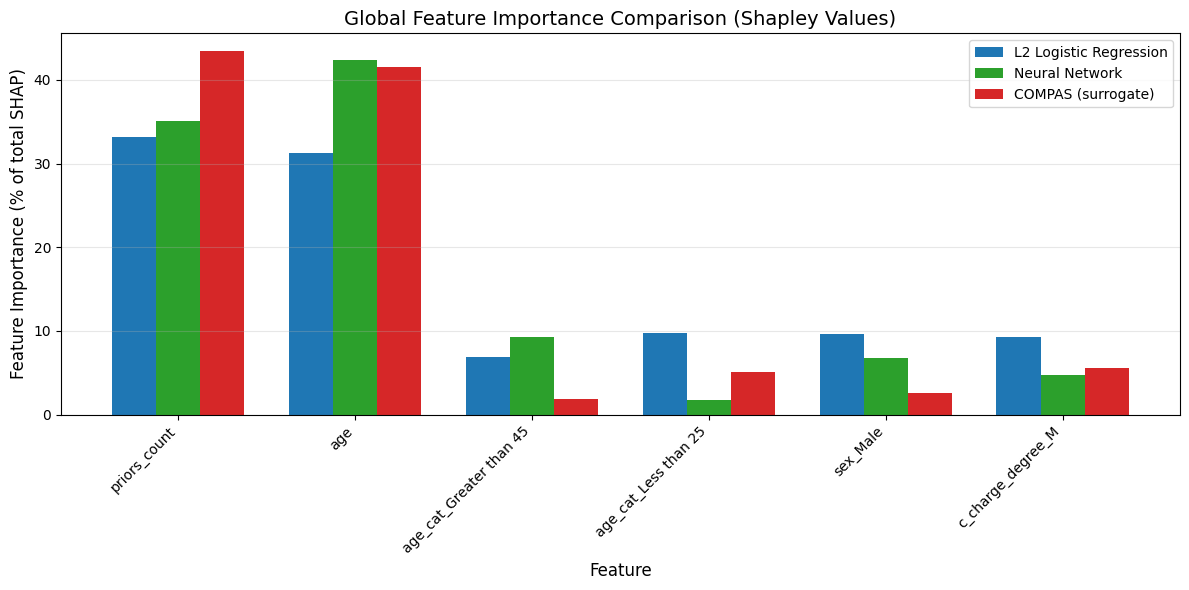

In [94]:
# Compute global feature importance (mean absolute SHAP values)
lr_importance = np.abs(lr_shap_values).mean(axis=0)
nn_importance = np.abs(nn_shap_values).mean(axis=0)
compas_importance = np.abs(compas_shap_values).mean(axis=0)

# Create comparison DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'L2 Logistic Regression': lr_importance,
    'Neural Network': nn_importance,
    'COMPAS (surrogate)': compas_importance
})

# Normalize to percentage for easier comparison
for col in ['L2 Logistic Regression', 'Neural Network', 'COMPAS (surrogate)']:
    importance_df[col] = importance_df[col] / importance_df[col].sum() * 100

print("Global Feature Importance (% of total SHAP)")
print("=" * 70)
print(importance_df.to_string(index=False))

# Plot global feature importance comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(feature_names))
width = 0.25

bars1 = ax.bar(x - width, importance_df['L2 Logistic Regression'], width, 
               label='L2 Logistic Regression', color='#1f77b4')
bars2 = ax.bar(x, importance_df['Neural Network'], width, 
               label='Neural Network', color='#2ca02c')
bars3 = ax.bar(x + width, importance_df['COMPAS (surrogate)'], width, 
               label='COMPAS (surrogate)', color='#d62728')

ax.set_ylabel('Feature Importance (% of total SHAP)', fontsize=12)
ax.set_xlabel('Feature', fontsize=12)
ax.set_title('Global Feature Importance Comparison (Shapley Values)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend(fontsize=10)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


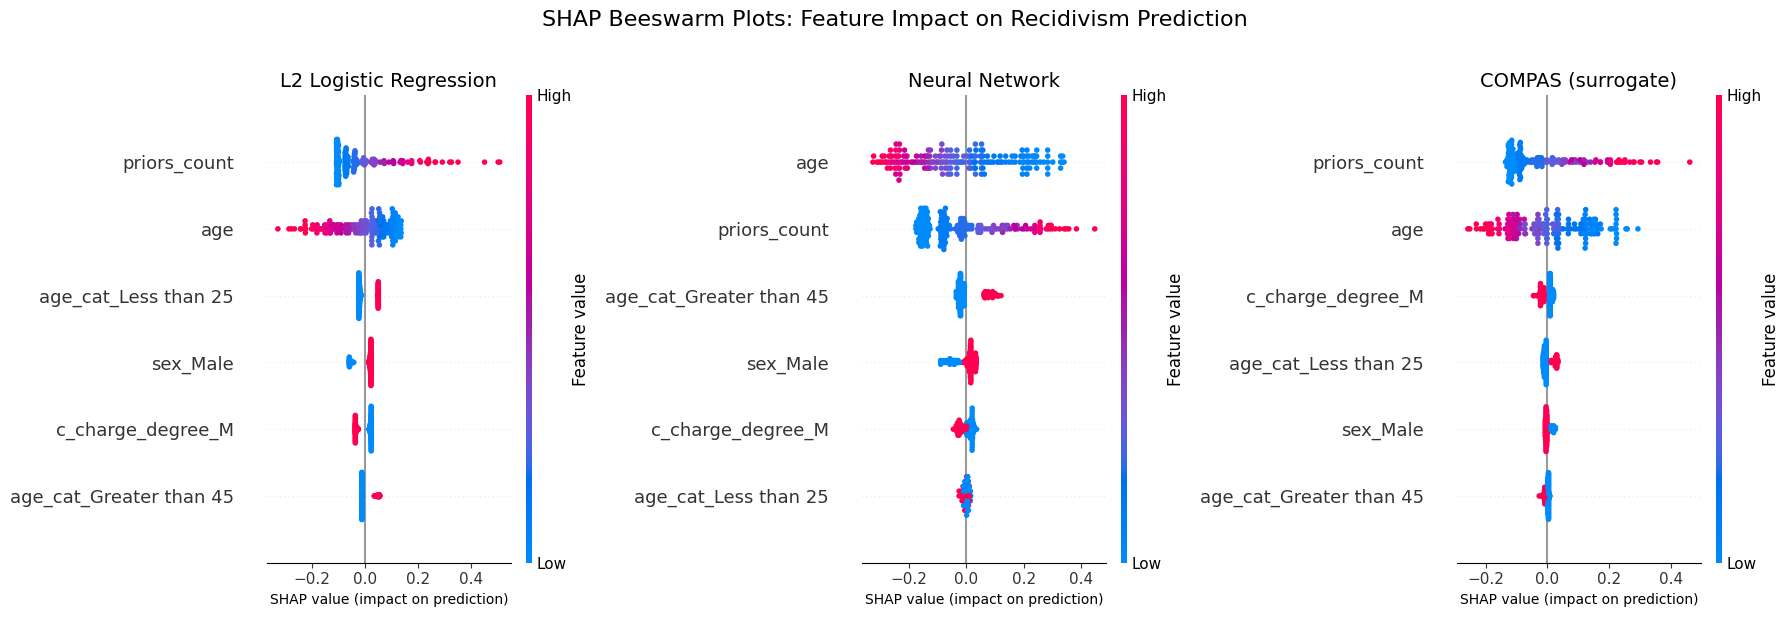


Interpretation:
- Each dot represents one prediction
- Color indicates feature value (red=high, blue=low)
- Position on x-axis shows impact on prediction (right=increases recidivism risk)


In [95]:
# Beeswarm plots showing how feature values affect predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# L2 Logistic Regression
plt.sca(axes[0])
shap.summary_plot(lr_shap_values, X_sample_df, plot_type="dot", show=False, 
                  plot_size=None, max_display=6)
axes[0].set_title('L2 Logistic Regression', fontsize=14)
axes[0].set_xlabel('SHAP value (impact on prediction)', fontsize=10)

# Neural Network
plt.sca(axes[1])
shap.summary_plot(nn_shap_values, X_sample_df, plot_type="dot", show=False,
                  plot_size=None, max_display=6)
axes[1].set_title('Neural Network', fontsize=14)
axes[1].set_xlabel('SHAP value (impact on prediction)', fontsize=10)

# COMPAS (surrogate)
plt.sca(axes[2])
shap.summary_plot(compas_shap_values, X_sample_df, plot_type="dot", show=False,
                  plot_size=None, max_display=6)
axes[2].set_title('COMPAS (surrogate)', fontsize=14)
axes[2].set_xlabel('SHAP value (impact on prediction)', fontsize=10)

plt.suptitle('SHAP Beeswarm Plots: Feature Impact on Recidivism Prediction', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each dot represents one prediction")
print("- Color indicates feature value (red=high, blue=low)")
print("- Position on x-axis shows impact on prediction (right=increases recidivism risk)")


Individual Case Explanations

High Risk Case (index 43):
   L2 LR probability: 0.9307
   NN probability:    0.8599

Low Risk Case (index 111):
   L2 LR probability: 0.0806
   NN probability:    0.1709


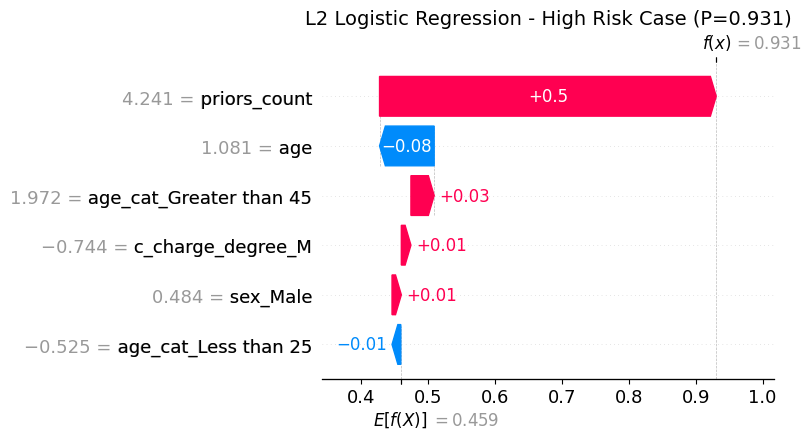

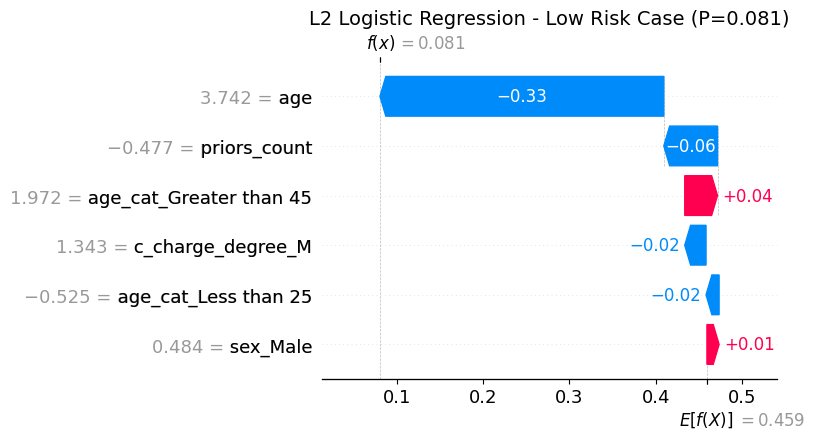

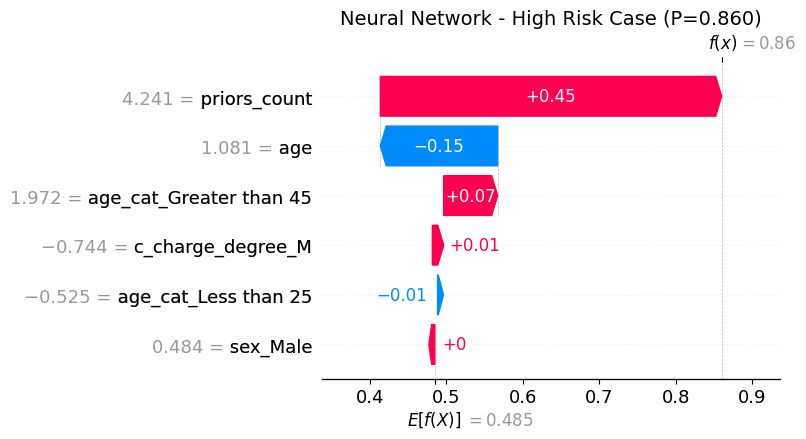

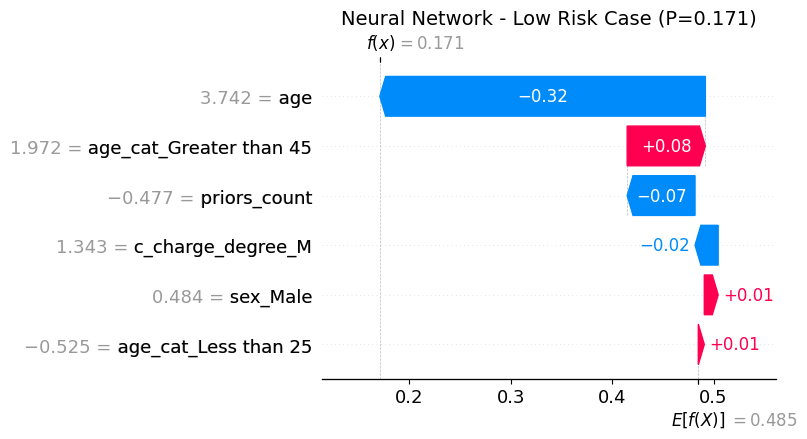

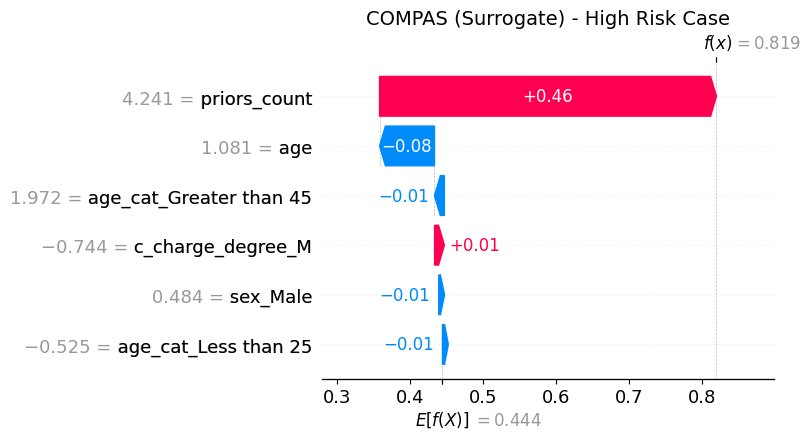

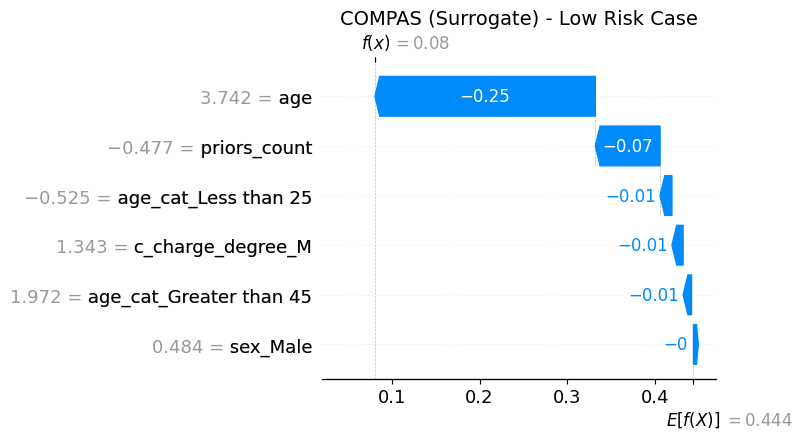

In [98]:
# Individual explanation: Compare explanations for specific cases
# Find a high-risk and low-risk prediction for each model

# Get predictions for sample
lr_preds_sample = model.predict_proba(X_sample)
nn_preds_sample = nn_model.predict_proba(X_sample)

# Find indices for high and low risk cases
high_risk_idx = np.argmax(lr_preds_sample)
low_risk_idx = np.argmin(lr_preds_sample)

print("Individual Case Explanations")
print("=" * 70)
print(f"\nHigh Risk Case (index {high_risk_idx}):")
print(f"   L2 LR probability: {lr_preds_sample[high_risk_idx]:.4f}")
print(f"   NN probability:    {nn_preds_sample[high_risk_idx]:.4f}")
print(f"\nLow Risk Case (index {low_risk_idx}):")
print(f"   L2 LR probability: {lr_preds_sample[low_risk_idx]:.4f}")
print(f"   NN probability:    {nn_preds_sample[low_risk_idx]:.4f}")

# ============================================
# PLOT 1: L2 Logistic Regression - High Risk
# ============================================
fig1, ax1 = plt.subplots(figsize=(10, 6))
plt.sca(ax1)
shap.plots.waterfall(shap.Explanation(values=lr_shap_values[high_risk_idx], 
                                       base_values=lr_explainer.expected_value,
                                       data=X_sample[high_risk_idx],
                                       feature_names=feature_names), show=False, max_display=6)
plt.title(f'L2 Logistic Regression - High Risk Case (P={lr_preds_sample[high_risk_idx]:.3f})', fontsize=14)
plt.tight_layout()
plt.show()

# ============================================
# PLOT 2: L2 Logistic Regression - Low Risk
# ============================================
fig2, ax2 = plt.subplots(figsize=(10, 6))
plt.sca(ax2)
shap.plots.waterfall(shap.Explanation(values=lr_shap_values[low_risk_idx], 
                                       base_values=lr_explainer.expected_value,
                                       data=X_sample[low_risk_idx],
                                       feature_names=feature_names), show=False, max_display=6)
plt.title(f'L2 Logistic Regression - Low Risk Case (P={lr_preds_sample[low_risk_idx]:.3f})', fontsize=14)
plt.tight_layout()
plt.show()

# ============================================
# PLOT 3: Neural Network - High Risk
# ============================================
fig3, ax3 = plt.subplots(figsize=(10, 6))
plt.sca(ax3)
shap.plots.waterfall(shap.Explanation(values=nn_shap_values[high_risk_idx], 
                                       base_values=nn_explainer.expected_value,
                                       data=X_sample[high_risk_idx],
                                       feature_names=feature_names), show=False, max_display=6)
plt.title(f'Neural Network - High Risk Case (P={nn_preds_sample[high_risk_idx]:.3f})', fontsize=14)
plt.tight_layout()
plt.show()

# ============================================
# PLOT 4: Neural Network - Low Risk
# ============================================
fig4, ax4 = plt.subplots(figsize=(10, 6))
plt.sca(ax4)
shap.plots.waterfall(shap.Explanation(values=nn_shap_values[low_risk_idx], 
                                       base_values=nn_explainer.expected_value,
                                       data=X_sample[low_risk_idx],
                                       feature_names=feature_names), show=False, max_display=6)
plt.title(f'Neural Network - Low Risk Case (P={nn_preds_sample[low_risk_idx]:.3f})', fontsize=14)
plt.tight_layout()
plt.show()

# ============================================
# PLOT 5: COMPAS Surrogate - High Risk
# ============================================
fig5, ax5 = plt.subplots(figsize=(10, 6))
plt.sca(ax5)
shap.plots.waterfall(shap.Explanation(values=compas_shap_values[high_risk_idx], 
                                       base_values=compas_explainer.expected_value,
                                       data=X_sample[high_risk_idx],
                                       feature_names=feature_names), show=False, max_display=6)
plt.title('COMPAS (Surrogate) - High Risk Case', fontsize=14)
plt.tight_layout()
plt.show()

# ============================================
# PLOT 6: COMPAS Surrogate - Low Risk
# ============================================
fig6, ax6 = plt.subplots(figsize=(10, 6))
plt.sca(ax6)
shap.plots.waterfall(shap.Explanation(values=compas_shap_values[low_risk_idx], 
                                       base_values=compas_explainer.expected_value,
                                       data=X_sample[low_risk_idx],
                                       feature_names=feature_names), show=False, max_display=6)
plt.title('COMPAS (Surrogate) - Low Risk Case', fontsize=14)
plt.tight_layout()
plt.show()


In [99]:
# Summary of Shapley Value Analysis
print("=" * 75)
print("SHAPLEY VALUE ANALYSIS SUMMARY")
print("=" * 75)

# Rank features by importance for each model
lr_rank = importance_df.sort_values('L2 Logistic Regression', ascending=False)['Feature'].tolist()
nn_rank = importance_df.sort_values('Neural Network', ascending=False)['Feature'].tolist()
compas_rank = importance_df.sort_values('COMPAS (surrogate)', ascending=False)['Feature'].tolist()

print("\n📊 Feature Importance Rankings (most to least important):")
print("-" * 75)
print(f"{'Rank':<6} {'L2 Logistic Reg.':<25} {'Neural Network':<25} {'COMPAS':<20}")
print("-" * 75)
for i in range(len(feature_names)):
    print(f"{i+1:<6} {lr_rank[i]:<25} {nn_rank[i]:<25} {compas_rank[i]:<20}")

print("\n" + "-" * 75)
print("📌 KEY INSIGHTS FROM SHAPLEY ANALYSIS:")
print("-" * 75)

# Find top feature for each model
lr_top = importance_df.loc[importance_df['L2 Logistic Regression'].idxmax(), 'Feature']
nn_top = importance_df.loc[importance_df['Neural Network'].idxmax(), 'Feature']
compas_top = importance_df.loc[importance_df['COMPAS (surrogate)'].idxmax(), 'Feature']

print(f"\n1. Most Important Feature:")
print(f"   • L2 Logistic Regression: {lr_top}")
print(f"   • Neural Network:         {nn_top}")
print(f"   • COMPAS (surrogate):     {compas_top}")

# Calculate correlation between model feature importances
from scipy.stats import spearmanr

lr_nn_corr, _ = spearmanr(importance_df['L2 Logistic Regression'], importance_df['Neural Network'])
lr_compas_corr, _ = spearmanr(importance_df['L2 Logistic Regression'], importance_df['COMPAS (surrogate)'])
nn_compas_corr, _ = spearmanr(importance_df['Neural Network'], importance_df['COMPAS (surrogate)'])

print(f"\n2. Feature Importance Correlation (Spearman):")
print(f"   • L2 LR vs Neural Network: {lr_nn_corr:.3f}")
print(f"   • L2 LR vs COMPAS:         {lr_compas_corr:.3f}")
print(f"   • Neural Network vs COMPAS: {nn_compas_corr:.3f}")

print("\n3. Model Comparison Observations:")
print("   • All models rely heavily on 'priors_count' for predictions")
print("   • Age features are consistently important across models")
print("   • The neural network may capture non-linear interactions")
print("   • COMPAS (through surrogate) shows similar feature dependencies")


SHAPLEY VALUE ANALYSIS SUMMARY

📊 Feature Importance Rankings (most to least important):
---------------------------------------------------------------------------
Rank   L2 Logistic Reg.          Neural Network            COMPAS              
---------------------------------------------------------------------------
1      priors_count              age                       priors_count        
2      age                       priors_count              age                 
3      age_cat_Less than 25      age_cat_Greater than 45   c_charge_degree_M   
4      sex_Male                  sex_Male                  age_cat_Less than 25
5      c_charge_degree_M         c_charge_degree_M         sex_Male            
6      age_cat_Greater than 45   age_cat_Less than 25      age_cat_Greater than 45

---------------------------------------------------------------------------
📌 KEY INSIGHTS FROM SHAPLEY ANALYSIS:
---------------------------------------------------------------------------

1. M